In [4]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import itertools
import statsmodels.api as sm
from sklearn.externals import joblib
from datetime import datetime
import seaborn as sns
from functools import reduce

In [5]:
import plotly.express as px

In [6]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [7]:
download = drive.CreateFile({'id': '1nFO2e1KwCC56erKuNbWJYqGkVJe_97Wi'})
download.GetContentFile('IT_Support_Cases.xlsx')

In [8]:
data = pd.read_csv('IT_Support_Cases.xlsx', encoding = "ISO-8859-1")

In [9]:
data

,INCIDENT_NUMBER,INCIDENT_IMPACTED_USER,LABEL,ASSIGNEE_EMAIL,INCIDENT_SUMMARY,INCIDENT_NOTES,INCIDENT_STATE,IMPACTED_SERVICE,IMPACTED_SERVICE_OFFERING,ASSIGNMENT_GROUP,ASSIGNEMENT_SUPPORT_LEVEL,INCIDENT_CATEGORY,INCIDENT_SUBCATEGORY,FIRST_ASSIGNED_TIME,INCIDENT_OPENED_AT_DATE,INCIDENT_OPENED_FIS_MONTH,INCIDENT_OPENED_FIS_QUARTER,INCIDENT_OPENED_FIS_YEAR,INCIDENT_RESOLVED_AT_DATE,INCIDENT_CLOSED_AT_DATE,HR_COUNTRY,REGION,HR_THEATRE,DV_BUILDING,INCIDENT_RESOLVED_FIS_WEEK,INCIDENT_RESOLVED_FIS_MONTH,INCIDENT_RESOLVED_FIS_QUARTER,INCIDENT_RESOLVED_FIS_YEAR,INCIDENT_RESOLUTION_DOMAIN,INCIDENT_RESOLUTION_ACTION,INCIDENT_RESOLUTION_AREA,INCIDENT_RESOLUTION_NOTES,INCIDENT_IMPACTED_AREA,Priority
0,INC1603712,NaN,Monitoring,vinwilso@cisco.com,EUROPE1 - dbi03-lmr-gw1.cisco.com: Device not ...,EUROPE1 - dbi03-lmr-gw1.cisco.com: Device not ...,Cancelled,Corporate Network,Secure WAN Access,Network-Ops-Premise-NOC,Tier 2,Performance,Degraded,11-Jun-19,12-JUN-19 06.55.34.000000000,FY2019 MON 11 (JUN),FY2019 Q4,FY2019,NaN,12-JUN-19 07.10.15.000000000,UNITED ARAB EMIRATES,EMERGING,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5 - Standard
1,INC2987458,francig3,Phone,mmartenc@cisco.com,Audio Issues (Poor Quality),*** Incident Reported ***\r\n\r\n Reported By...,Pending,Cloud Collaboration,Webex Teams,RCSS,Tier 1,Performance,Degraded,12-Jan-21,12-JAN-21 15.44.37.000000000,FY2021 MON 06 (JAN),FY2021 Q2,FY2021,NaN,NaN,PORTUGAL,EMEAR-SOUTH,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",OEIRAS 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voice - windows,5 - Standard
2,INC2987462,denkraus,Phone,mmartenc@cisco.com,Audio Issues (Poor Quality),*** Incident Reported ***\r\n\r\n Reported By...,Pending,Cloud Collaboration,Webex Teams,RCSS,Tier 1,Performance,Degraded,12-Jan-21,12-JAN-21 15.46.22.000000000,FY2021 MON 06 (JAN),FY2021 Q2,FY2021,NaN,NaN,PORTUGAL,EMEAR-SOUTH,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",OEIRAS 5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Voice - windows,5 - Standard
3,INC0024169,fvaningh,Email,fvaningh@cisco.com,[VF] stk03 primary link RtD value slightly hig...,problem: RtD of new WAN link is higher than be...,Cancelled,Corporate Network,Secure WAN Access,Network-Ops-Premise-NOC,Tier 2,Performance,Function Not Working,02-Oct-17,02-OCT-17 08.00.23.000000000,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,NaN,21-NOV-17 13.53.25.000000000,SWEDEN,EMEAR-NORTH,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",DIEGEM - PEGASUS 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WAN Carrier,5 - Standard
4,INC0041143,tompeete,Email,fvaningh@cisco.com,[VF] high RTD on primary wan link in nue01,"problem: after the WAN transformation, the rtd...",Cancelled,Corporate Network,Secure WAN Access,Network-Ops-Premise-NOC,Tier 2,Performance,Function Not Working,18-Oct-17,07-OCT-17 15.52.22.000000000,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,NaN,21-NOV-17 13.49.05.000000000,GERMANY,EMEAR-CENTRAL,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",DIEGEM - PEGASUS 2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,WAN Carrier,5 - Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84414,INC1435204,trimkus,Phone,kamalve@cisco.com,RTS>>UK NUMBER : +44 2088244031 : Requires to ...,UK NUMBER : +44 2088244031 : Requires to be se...,Closed,Collaboration Platform and Voice Services,IP Phone & Features,TechSupport-Remote-EMEAR-T2-UC-Incident,Tier 2 - EMEAR,Error,Data,09-Apr-19,09-APR-19 11.23.08.000000000,FY2019 MON 09 (APR),FY2019 Q3,FY2019,09-APR-19 20.43.25.000000000,15-APR-19 10.01.49.000000000,IRELAND,UK and IRELAND,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",NaN,FY2019 Q3 WK11,FY2019 MON 09 (APR),FY2019 Q3,FY2019,Job/Workflow,Manual Intervention,Secondary Extension,\r\nSummary : \r\n \r\nIssue : \r\n++++++++++...,Extension Mobility (EM),4 - Minor
84415,INC1953112,sdeboeck,Monitoring,susiddab@cisco.com,"Event Management - Tokyo, Japan composite gate...",https://cisco.service-now.com/nav_to.do?uri=%2...,Closed,Corporate Network

In [10]:
data['INCIDENT_RESOLVED_AT_DATE'].isna().sum()

801

In [11]:
data_notna = data[data['INCIDENT_RESOLVED_AT_DATE'].notna()]

In [12]:
data_notna = data_notna[data_notna['INCIDENT_CLOSED_AT_DATE'].notna()]

In [13]:
data_notna['INCIDENT_CLOSED_AT_DATE'].isna().sum()

0

In [14]:
data_notna

,INCIDENT_NUMBER,INCIDENT_IMPACTED_USER,LABEL,ASSIGNEE_EMAIL,INCIDENT_SUMMARY,INCIDENT_NOTES,INCIDENT_STATE,IMPACTED_SERVICE,IMPACTED_SERVICE_OFFERING,ASSIGNMENT_GROUP,ASSIGNEMENT_SUPPORT_LEVEL,INCIDENT_CATEGORY,INCIDENT_SUBCATEGORY,FIRST_ASSIGNED_TIME,INCIDENT_OPENED_AT_DATE,INCIDENT_OPENED_FIS_MONTH,INCIDENT_OPENED_FIS_QUARTER,INCIDENT_OPENED_FIS_YEAR,INCIDENT_RESOLVED_AT_DATE,INCIDENT_CLOSED_AT_DATE,HR_COUNTRY,REGION,HR_THEATRE,DV_BUILDING,INCIDENT_RESOLVED_FIS_WEEK,INCIDENT_RESOLVED_FIS_MONTH,INCIDENT_RESOLVED_FIS_QUARTER,INCIDENT_RESOLVED_FIS_YEAR,INCIDENT_RESOLUTION_DOMAIN,INCIDENT_RESOLUTION_ACTION,INCIDENT_RESOLUTION_AREA,INCIDENT_RESOLUTION_NOTES,INCIDENT_IMPACTED_AREA,Priority
5,INC0047845,almikhli,Phone,sgundami@cisco.com,<<IPHONE>>,>>almikhli called in ESTS regarding ip phone i...,Closed,Collaboration Platform and Voice Services,IP Phone,TechSupport-Remote-T1,Tier 1,Performance,Function Not Working,10-Oct-17,10-OCT-17 12.32.10.000000000,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,10-OCT-17 12.56.29.000000000,15-OCT-17 13.00.50.000000000,ISRAEL,EMEAR-SOUTH,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",NaN,FY2018 Q1 WK11,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,Service Request,NaN,NaN,>>resolved,NaN,5 - Standard
6,INC2077615,conradst,Email,mukhokha@cisco.com,BDLK10-1 App Dynamics Wireles Issues,Conrad Steven & others in the App Dynamics are...,Closed,Corporate Network,Secure LAN Access,Network-Ops-Premise,Tier 4,Performance,NaN,09-Dec-19,09-DEC-19 14.34.15.000000000,FY2020 MON 05 (DEC),FY2020 Q2,FY2020,15-DEC-19 12.00.11.000000000,15-DEC-19 12.00.11.000000000,UNITED KINGDOM,UK and IRELAND,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",BEDFONT LAKES 10,FY2020 Q2 WK08,FY2020 MON 05 (DEC),FY2020 Q2,FY2020,Hardware,NaN,NaN,\nIncident 'INC2077615' closed based on closur...,Wireless - Connectivity Issue,5 - Standard
10,INC0011890,lhegle,Phone,aperezro@cisco.com,lhegle@cisco.com // WebEx // WebEx recording p...,Incident Reported:\r\nName: Hegle Lee \r\nEmai...,Closed,Cloud Collaboration,Webex Meetings,RCSS,Tier 1,Performance,Degraded,13-Sep-17,13-SEP-17 09.17.54.000000000,FY2018 MON 02 (SEP),FY2018 Q1,FY2018,15-SEP-17 05.27.02.000000000,20-SEP-17 06.00.02.000000000,GERMANY,EMEAR-CENTRAL,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",MUNICH - GARCHING,FY2018 Q1 WK07,FY2018 MON 02 (SEP),FY2018 Q1,FY2018,Service Request,NaN,NaN,Resolution Note:\r\n--------------------\r\n**...,Webex conferencing - mac,5 - Standard
22,INC0013843,amitron,Portal,rchiruma@cisco.com,access to Rally is so slow because of routing ...,Reach me by: Via Email\r\n\r\nI'm using the Ra...,Closed,Corporate Network,Cloud Port Service,NETWORK-OPS-CORE,Tier 1,Performance,Degraded,25-Oct-17,27-SEP-17 07.09.29.000000000,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,25-OCT-17 19.51.27.000000000,30-OCT-17 20.00.26.000000000,ISRAEL,EMEAR-SOUTH,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",NaN,FY2018 Q1 WK13,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,Service Request,NaN,NaN,"This ticket is duplicate of INC0084310, closin...",NaN,5 - Standard
31,INC0065009,gkalauz,Phone,ndevangm@cisco.com,>>Not able to log into the IP phone,>>called in ESTS regarding issue\r\n>>Callback...,Closed,Collaboration Platform and Voice Services,IP Phone & Features,TechSupport-Remote-EMEAR-T2-UC-Incident,Tier 2 - EMEAR,Performance,Function Not Working,17-Oct-17,17-OCT-17 08.44.20.000000000,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,17-OCT-17 11.13.27.000000000,22-OCT-17 12.00.16.000000000,POLAND,EMEAR-CENTRAL,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",KRAKOW - ENTERPRISE PARK BLDG C,FY2018 Q1 WK12,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,Service Request,NaN,NaN,Reactivated EM 1 secondary extension number,NaN,5 - Standard
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84414,INC1435204,trimkus,Phone,kamalve@cisco.com,RTS>>UK NUMBER : +44 2088244031 : Requires to ...,UK NUMBER : +44 2088244031 : Requires to be se...,Closed,Collaboration Platform and Voice Servic

In [15]:
data_df = data_notna[['INCIDENT_NUMBER','INCIDENT_STATE', 'IMPACTED_SERVICE', 'INCIDENT_OPENED_AT_DATE', 'INCIDENT_RESOLVED_AT_DATE','INCIDENT_CLOSED_AT_DATE','Priority'	]]

In [16]:
data_df

,INCIDENT_NUMBER,INCIDENT_STATE,IMPACTED_SERVICE,INCIDENT_OPENED_AT_DATE,INCIDENT_RESOLVED_AT_DATE,INCIDENT_CLOSED_AT_DATE,Priority
5,INC0047845,Closed,Collaboration Platform and Voice Services,10-OCT-17 12.32.10.000000000,10-OCT-17 12.56.29.000000000,15-OCT-17 13.00.50.000000000,5 - Standard
6,INC2077615,Closed,Corporate Network,09-DEC-19 14.34.15.000000000,15-DEC-19 12.00.11.000000000,15-DEC-19 12.00.11.000000000,5 - Standard
10,INC0011890,Closed,Cloud Collaboration,13-SEP-17 09.17.54.000000000,15-SEP-17 05.27.02.000000000,20-SEP-17 06.00.02.000000000,5 - Standard
22,INC0013843,Closed,Corporate Network,27-SEP-17 07.09.29.000000000,25-OCT-17 19.51.27.000000000,30-OCT-17 20.00.26.000000000,5 - Standard
31,INC0065009,Closed,Collaboration Platform and Voice Services,17-OCT-17 08.44.20.000000000,17-OCT-17 11.13.27.000000000,22-OCT-17 12.00.16.000000000,5 - Standard
...,...,...,...,...,...,...,...
84414,INC1435204,Closed,Collaboration Platform and Voice Services,09-APR-19 11.23.08.000000000,09-APR-19 20.43.25.000000000,15-APR-19 10.01.49.000000000,4 - Minor
84415,INC1953112,Closed,Corporate Network,20-OCT-19 19.47.38.000000000,20-OCT-19 22.57.37.000000000,26-OCT-19 00.00.11.000000000,4 - Minor
84416,INC0739798,Closed,Expense Management,25-JUL-18 08.17.01.000000000,26-JUL-18 10.12.18.000000000,31-JUL-18 11.01.00.000000000,4 - Minor
84417,INC0588855,Closed,Cloud Collaboration,25-MAY-18 10.13.25.000000000,31-MAY-18 09.53.22.000000000,10-JUN-18 04.01.18.000000000,4 - Minor


In [17]:
# Are there NaNs in the Priority column? - No
data_df['Priority'].isna().sum()

0

In [18]:
# Calculating expected SLA using apply with axis=1
# def expected_sla_hours(row):
#   if(row.Priority == '5 - Standard'):
#     return 48
#   elif(row['Priority'] == '4 - Minor'):
#     return 24
#   elif(row['Priority'] == '3 - Moderate'):
#     return 8
#   elif(row['Priority'] == '2 - High'):
#     return 6
#   elif(row['Priority'] == '1 - Critical'):
#     return 4

# data_df.apply(expected_sla_hours, axis=1)

# Calculating expected SLA using apply:
def expected_sla_hours(priority):
  if(priority == '5 - Standard'):
    return 48
  elif(priority == '4 - Minor'):
    return 24
  elif(priority == '3 - Moderate'):
    return 8
  elif(priority == '2 - High'):
    return 6
  elif(priority == '1 - Critical'):
    return 4

data_df['EXPECTED_SLA'] = data_df['Priority'].apply(expected_sla_hours)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [19]:
#Calculating expected SLA using map:
sla_dictionary = {'5 - Standard': 48, '4 - Minor': 24, '3 - Moderate': 8, '2 - High': 6, '1 - Critical': 4}

data_df['EXPECTED_SLA'] = data_df['Priority'].map(sla_dictionary)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [20]:
data_df

,INCIDENT_NUMBER,INCIDENT_STATE,IMPACTED_SERVICE,INCIDENT_OPENED_AT_DATE,INCIDENT_RESOLVED_AT_DATE,INCIDENT_CLOSED_AT_DATE,Priority,EXPECTED_SLA
5,INC0047845,Closed,Collaboration Platform and Voice Services,10-OCT-17 12.32.10.000000000,10-OCT-17 12.56.29.000000000,15-OCT-17 13.00.50.000000000,5 - Standard,48
6,INC2077615,Closed,Corporate Network,09-DEC-19 14.34.15.000000000,15-DEC-19 12.00.11.000000000,15-DEC-19 12.00.11.000000000,5 - Standard,48
10,INC0011890,Closed,Cloud Collaboration,13-SEP-17 09.17.54.000000000,15-SEP-17 05.27.02.000000000,20-SEP-17 06.00.02.000000000,5 - Standard,48
22,INC0013843,Closed,Corporate Network,27-SEP-17 07.09.29.000000000,25-OCT-17 19.51.27.000000000,30-OCT-17 20.00.26.000000000,5 - Standard,48
31,INC0065009,Closed,Collaboration Platform and Voice Services,17-OCT-17 08.44.20.000000000,17-OCT-17 11.13.27.000000000,22-OCT-17 12.00.16.000000000,5 - Standard,48
...,...,...,...,...,...,...,...,...
84414,INC1435204,Closed,Collaboration Platform and Voice Services,09-APR-19 11.23.08.000000000,09-APR-19 20.43.25.000000000,15-APR-19 10.01.49.000000000,4 - Minor,24
84415,INC1953112,Closed,Corporate Network,20-OCT-19 19.47.38.000000000,20-OCT-19 22.57.37.000000000,26-OCT-19 00.00.11.000000000,4 - Minor,24
84416,INC0739798,Closed,Expense Management,25-JUL-18 08.17.01.000000000,26-JUL-18 10.12.18.000000000,31-JUL-18 11.01.00.000000000,4 - Minor,24
84417,INC0588855,Closed,Cloud Collaboration,25-MAY-18 10.13.25.000000000,31-MAY-18 09.53.22.000000000,10-JUN-18 04.01.18.000000000,4 - Minor,24


In [21]:
#Strip the trailing zeros from date columns and convert them to datetime objects

data_df['INCIDENT_OPENED_AT_DATE'] = data_df['INCIDENT_OPENED_AT_DATE'].apply(lambda x: datetime.strptime(x[0:-10], "%d-%b-%y %H.%M.%S"))
data_df['INCIDENT_RESOLVED_AT_DATE'] = data_df['INCIDENT_RESOLVED_AT_DATE'].apply(lambda x: datetime.strptime(x[0:-10], "%d-%b-%y %H.%M.%S"))
data_df['INCIDENT_CLOSED_AT_DATE'] = data_df['INCIDENT_CLOSED_AT_DATE'].apply(lambda x: datetime.strptime(x[0:-10], "%d-%b-%y %H.%M.%S"))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [22]:
data_df

,INCIDENT_NUMBER,INCIDENT_STATE,IMPACTED_SERVICE,INCIDENT_OPENED_AT_DATE,INCIDENT_RESOLVED_AT_DATE,INCIDENT_CLOSED_AT_DATE,Priority,EXPECTED_SLA
5,INC0047845,Closed,Collaboration Platform and Voice Services,2017-10-10 12:32:10,2017-10-10 12:56:29,2017-10-15 13:00:50,5 - Standard,48
6,INC2077615,Closed,Corporate Network,2019-12-09 14:34:15,2019-12-15 12:00:11,2019-12-15 12:00:11,5 - Standard,48
10,INC0011890,Closed,Cloud Collaboration,2017-09-13 09:17:54,2017-09-15 05:27:02,2017-09-20 06:00:02,5 - Standard,48
22,INC0013843,Closed,Corporate Network,2017-09-27 07:09:29,2017-10-25 19:51:27,2017-10-30 20:00:26,5 - Standard,48
31,INC0065009,Closed,Collaboration Platform and Voice Services,2017-10-17 08:44:20,2017-10-17 11:13:27,2017-10-22 12:00:16,5 - Standard,48
...,...,...,...,...,...,...,...,...
84414,INC1435204,Closed,Collaboration Platform and Voice Services,2019-04-09 11:23:08,2019-04-09 20:43:25,2019-04-15 10:01:49,4 - Minor,24
84415,INC1953112,Closed,Corporate Network,2019-10-20 19:47:38,2019-10-20 22:57:37,2019-10-26 00:00:11,4 - Minor,24
84416,INC0739798,Closed,Expense Management,2018-07-25 08:17:01,2018-07-26 10:12:18,2018-07-31 11:01:00,4 - Minor,24
84417,INC0588855,Closed,Cloud Collaboration,2018-05-25 10:13:25,2018-05-31 09:53:22,2018-06-10 04:01:18,4 - Minor,24


In [23]:
# Calculate the actual resolution time

data_df['RESOLUTION_TIME'] = (data_df['INCIDENT_RESOLVED_AT_DATE'].apply(lambda x: datetime.timestamp(x)) - data_df['INCIDENT_OPENED_AT_DATE'].apply(lambda x: datetime.timestamp(x)))/3600

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [24]:
# data_df['SLA_MET'] = data_df['RESOLUTION_TIME'] <= data_df['EXPECTED_SLA']
data_df['SLA_MISSED'] = data_df['RESOLUTION_TIME'] > data_df['EXPECTED_SLA']

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [25]:
data_df['SLA_BREACHED_BY'] = np.where((data_df['RESOLUTION_TIME'] > data_df['EXPECTED_SLA']), data_df['RESOLUTION_TIME'] - data_df['EXPECTED_SLA'], np.nan)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [26]:
data_df

,INCIDENT_NUMBER,INCIDENT_STATE,IMPACTED_SERVICE,INCIDENT_OPENED_AT_DATE,INCIDENT_RESOLVED_AT_DATE,INCIDENT_CLOSED_AT_DATE,Priority,EXPECTED_SLA,RESOLUTION_TIME,SLA_MISSED,SLA_BREACHED_BY
5,INC0047845,Closed,Collaboration Platform and Voice Services,2017-10-10 12:32:10,2017-10-10 12:56:29,2017-10-15 13:00:50,5 - Standard,48,0.405278,False,NaN
6,INC2077615,Closed,Corporate Network,2019-12-09 14:34:15,2019-12-15 12:00:11,2019-12-15 12:00:11,5 - Standard,48,141.432222,True,93.432222
10,INC0011890,Closed,Cloud Collaboration,2017-09-13 09:17:54,2017-09-15 05:27:02,2017-09-20 06:00:02,5 - Standard,48,44.152222,False,NaN
22,INC0013843,Closed,Corporate Network,2017-09-27 07:09:29,2017-10-25 19:51:27,2017-10-30 20:00:26,5 - Standard,48,684.699444,True,636.699444
31,INC0065009,Closed,Collaboration Platform and Voice Services,2017-10-17 08:44:20,2017-10-17 11:13:27,2017-10-22 12:00:16,5 - Standard,48,2.485278,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...
84414,INC1435204,Closed,Collaboration Platform and Voice Services,2019-04-09 11:23:08,2019-04-09 20:43:25,2019-04-15 10:01:49,4 - Minor,24,9.338056,False,NaN
84415,INC1953112,Closed,Corporate Network,2019-10-20 19:47:38,2019-10-20 22:57:37,2019-10-26 00:00:11,4 - Minor,24,3.166389,False,NaN
84416,INC0739798,Closed,Expense Management,2018-07-25 08:17:01,2018-07-26 10:12:18,2018-07-31 11:01:00,4 - Minor,24,25.921389,True,1.921389
84417,INC0588855,Closed,Cloud Collaboration,2018-05-25 10:13:25,2018-05-31 09:53:22,2018-06-10 04:01:18,4 - Minor,24,143.665833,True,119.665833


In [27]:
# For how many cases was the SLA met vs breached/missed
data_df['SLA_MISSED'].value_counts()

False    46288
True     37042
Name: SLA_MISSED, dtype: int64

In [28]:
# Generating the excel file with SLA details added

sla_dictionary = {'5 - Standard': 48, '4 - Minor': 24, '3 - Moderate': 8, '2 - High': 6, '1 - Critical': 4}

data_notna['EXPECTED_SLA'] = data_notna['Priority'].map(sla_dictionary)

data_notna['INCIDENT_OPENED_AT_DATE'] = data_notna['INCIDENT_OPENED_AT_DATE'].apply(lambda x: datetime.strptime(x[0:-10], "%d-%b-%y %H.%M.%S"))
data_notna['INCIDENT_RESOLVED_AT_DATE'] = data_notna['INCIDENT_RESOLVED_AT_DATE'].apply(lambda x: datetime.strptime(x[0:-10], "%d-%b-%y %H.%M.%S"))
data_notna['INCIDENT_CLOSED_AT_DATE'] = data_notna['INCIDENT_CLOSED_AT_DATE'].apply(lambda x: datetime.strptime(x[0:-10], "%d-%b-%y %H.%M.%S"))

data_notna['RESOLUTION_TIME'] = (data_notna['INCIDENT_RESOLVED_AT_DATE'].apply(lambda x: datetime.timestamp(x)) - data_notna['INCIDENT_OPENED_AT_DATE'].apply(lambda x: datetime.timestamp(x)))/3600

data_notna['SLA_MISSED'] = data_notna['RESOLUTION_TIME'] > data_notna['EXPECTED_SLA']

data_notna['SLA_BREACHED_BY'] = np.where((data_notna['RESOLUTION_TIME'] > data_notna['EXPECTED_SLA']), data_notna['RESOLUTION_TIME'] - data_notna['EXPECTED_SLA'], np.nan)

**List for plots**
  1. IMPACTED_SERVICE
  2. ASSIGNMENT_GROUP
  3. IMPACTED_SERVICE_OFFERING
  4. INCIDENT_CATEGORY
  5. INCIDENT_SUBCATEGORY
  6. Priority
  7. HR_COUNTRY
  8. REGION


### **PRIORITY**

In [29]:
data_notna.groupby(['Priority','SLA_MISSED']).count()

INCIDENT_NUMBER  ...  SLA_BREACHED_BY
Priority     SLA_MISSED                   ...                 
1 - Critical False                     5  ...                0
             True                     66  ...               66
2 - High     False                     6  ...                0
             True                     31  ...               31
3 - Moderate False                    78  ...                0
             True                   1390  ...             1390
4 - Minor    False                   184  ...                0
             True                   1039  ...             1039
5 - Standard False                 46015  ...                0
             True                  34516  ...            34516

[10 rows x 36 columns]

In [30]:
data_notna.groupby('Priority').count()

,INCIDENT_NUMBER,INCIDENT_IMPACTED_USER,LABEL,ASSIGNEE_EMAIL,INCIDENT_SUMMARY,INCIDENT_NOTES,INCIDENT_STATE,IMPACTED_SERVICE,IMPACTED_SERVICE_OFFERING,ASSIGNMENT_GROUP,ASSIGNEMENT_SUPPORT_LEVEL,INCIDENT_CATEGORY,INCIDENT_SUBCATEGORY,FIRST_ASSIGNED_TIME,INCIDENT_OPENED_AT_DATE,INCIDENT_OPENED_FIS_MONTH,INCIDENT_OPENED_FIS_QUARTER,INCIDENT_OPENED_FIS_YEAR,INCIDENT_RESOLVED_AT_DATE,INCIDENT_CLOSED_AT_DATE,HR_COUNTRY,REGION,HR_THEATRE,DV_BUILDING,INCIDENT_RESOLVED_FIS_WEEK,INCIDENT_RESOLVED_FIS_MONTH,INCIDENT_RESOLVED_FIS_QUARTER,INCIDENT_RESOLVED_FIS_YEAR,INCIDENT_RESOLUTION_DOMAIN,INCIDENT_RESOLUTION_ACTION,INCIDENT_RESOLUTION_AREA,INCIDENT_RESOLUTION_NOTES,INCIDENT_IMPACTED_AREA,EXPECTED_SLA,RESOLUTION_TIME,SLA_MISSED,SLA_BREACHED_BY
Priority,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1 - Critical,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,71,60,71,71,71,71,71,71,46,71,56,71,71,71,66
2 - High,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,37,30,37,37,37,37,37,37,24,36,28,37,37,37,31
3 - Moderate,1468,1169,1468,1468,1468,1467,1468,1468,1468,1468,1467,1468,1468,1468,1468,1468,1468,1468,1468,1468,1468,1468,1468,427,1468,1468,1468,1468,1468,1468,1246,1423,1365,1468,1468,1468,1390
4 - Minor,1223,708,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,1223,136,1223,1223,1223,1223,1222,1221,872,1173,966,1223,1223,1223,1039
5 - Standard,80531,79776,80531,80519,80520,80530,80531,80531,80531,80531,80332,80530,80529,80527,80531,80531,80531,80531,80531,80531,80531,80531,80530,68270,80531,80531,80531,80531,80529,80379,63840,80246,64397,80531,80531,80531,34516


**More cases miss SLAs than meet them for priorities 1-4**

In [31]:
data_notna.groupby(['Priority','SLA_MISSED']).size().reset_index(name = 'Count')

,Priority,SLA_MISSED,Count
0,1 - Critical,False,5
1,1 - Critical,True,66
2,2 - High,False,6
3,2 - High,True,31
4,3 - Moderate,False,78
5,3 - Moderate,True,1390
6,4 - Minor,False,184
7,4 - Minor,True,1039
8,5 - Standard,False,46015
9,5 - Standard,True,34516


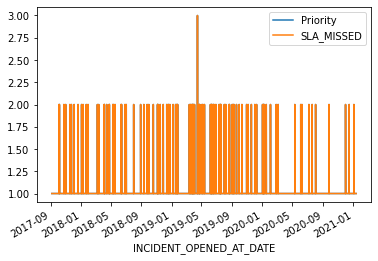

In [32]:
data_notna[['INCIDENT_OPENED_AT_DATE','Priority','SLA_MISSED']].groupby(['INCIDENT_OPENED_AT_DATE']).count().plot()

In [33]:
# df = pd.read_csv('data_1.csv')
df = data_notna.copy()

In [34]:
df

,INCIDENT_NUMBER,INCIDENT_IMPACTED_USER,LABEL,ASSIGNEE_EMAIL,INCIDENT_SUMMARY,INCIDENT_NOTES,INCIDENT_STATE,IMPACTED_SERVICE,IMPACTED_SERVICE_OFFERING,ASSIGNMENT_GROUP,ASSIGNEMENT_SUPPORT_LEVEL,INCIDENT_CATEGORY,INCIDENT_SUBCATEGORY,FIRST_ASSIGNED_TIME,INCIDENT_OPENED_AT_DATE,INCIDENT_OPENED_FIS_MONTH,INCIDENT_OPENED_FIS_QUARTER,INCIDENT_OPENED_FIS_YEAR,INCIDENT_RESOLVED_AT_DATE,INCIDENT_CLOSED_AT_DATE,HR_COUNTRY,REGION,HR_THEATRE,DV_BUILDING,INCIDENT_RESOLVED_FIS_WEEK,INCIDENT_RESOLVED_FIS_MONTH,INCIDENT_RESOLVED_FIS_QUARTER,INCIDENT_RESOLVED_FIS_YEAR,INCIDENT_RESOLUTION_DOMAIN,INCIDENT_RESOLUTION_ACTION,INCIDENT_RESOLUTION_AREA,INCIDENT_RESOLUTION_NOTES,INCIDENT_IMPACTED_AREA,Priority,EXPECTED_SLA,RESOLUTION_TIME,SLA_MISSED,SLA_BREACHED_BY
5,INC0047845,almikhli,Phone,sgundami@cisco.com,<<IPHONE>>,>>almikhli called in ESTS regarding ip phone i...,Closed,Collaboration Platform and Voice Services,IP Phone,TechSupport-Remote-T1,Tier 1,Performance,Function Not Working,10-Oct-17,2017-10-10 12:32:10,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,2017-10-10 12:56:29,2017-10-15 13:00:50,ISRAEL,EMEAR-SOUTH,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",NaN,FY2018 Q1 WK11,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,Service Request,NaN,NaN,>>resolved,NaN,5 - Standard,48,0.405278,False,NaN
6,INC2077615,conradst,Email,mukhokha@cisco.com,BDLK10-1 App Dynamics Wireles Issues,Conrad Steven & others in the App Dynamics are...,Closed,Corporate Network,Secure LAN Access,Network-Ops-Premise,Tier 4,Performance,NaN,09-Dec-19,2019-12-09 14:34:15,FY2020 MON 05 (DEC),FY2020 Q2,FY2020,2019-12-15 12:00:11,2019-12-15 12:00:11,UNITED KINGDOM,UK and IRELAND,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",BEDFONT LAKES 10,FY2020 Q2 WK08,FY2020 MON 05 (DEC),FY2020 Q2,FY2020,Hardware,NaN,NaN,\nIncident 'INC2077615' closed based on closur...,Wireless - Connectivity Issue,5 - Standard,48,141.432222,True,93.432222
10,INC0011890,lhegle,Phone,aperezro@cisco.com,lhegle@cisco.com // WebEx // WebEx recording p...,Incident Reported:\r\nName: Hegle Lee \r\nEmai...,Closed,Cloud Collaboration,Webex Meetings,RCSS,Tier 1,Performance,Degraded,13-Sep-17,2017-09-13 09:17:54,FY2018 MON 02 (SEP),FY2018 Q1,FY2018,2017-09-15 05:27:02,2017-09-20 06:00:02,GERMANY,EMEAR-CENTRAL,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",MUNICH - GARCHING,FY2018 Q1 WK07,FY2018 MON 02 (SEP),FY2018 Q1,FY2018,Service Request,NaN,NaN,Resolution Note:\r\n--------------------\r\n**...,Webex conferencing - mac,5 - Standard,48,44.152222,False,NaN
22,INC0013843,amitron,Portal,rchiruma@cisco.com,access to Rally is so slow because of routing ...,Reach me by: Via Email\r\n\r\nI'm using the Ra...,Closed,Corporate Network,Cloud Port Service,NETWORK-OPS-CORE,Tier 1,Performance,Degraded,25-Oct-17,2017-09-27 07:09:29,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,2017-10-25 19:51:27,2017-10-30 20:00:26,ISRAEL,EMEAR-SOUTH,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",NaN,FY2018 Q1 WK13,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,Service Request,NaN,NaN,"This ticket is duplicate of INC0084310, closin...",NaN,5 - Standard,48,684.699444,True,636.699444
31,INC0065009,gkalauz,Phone,ndevangm@cisco.com,>>Not able to log into the IP phone,>>called in ESTS regarding issue\r\n>>Callback...,Closed,Collaboration Platform and Voice Services,IP Phone & Features,TechSupport-Remote-EMEAR-T2-UC-Incident,Tier 2 - EMEAR,Performance,Function Not Working,17-Oct-17,2017-10-17 08:44:20,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,2017-10-17 11:13:27,2017-10-22 12:00:16,POLAND,EMEAR-CENTRAL,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",KRAKOW - ENTERPRISE PARK BLDG C,FY2018 Q1 WK12,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,Service Request,NaN,NaN,Reactivated EM 1 secondary extension number,NaN,5 - Standard,48,2.485278,False,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84414,INC1435204,trimkus,Phone,kamalve@cisco.com,RTS>>UK NUMBER : +44 2088244031 : Requires to ...,UK NUMBER : +44 2088244031 : Requ

In [35]:
# Use below piece of code if you read df from csv, else use the other piece of code.
# df['INCIDENT_OPENED_AT_DAY'] = df['INCIDENT_OPENED_AT_DATE'].apply(lambda x: x[0:-9])
# df['INCIDENT_OPENED_AT_DAY'] = pd.to_datetime(df['INCIDENT_OPENED_AT_DAY'], format='%Y-%m-%d')

# Remove the time of day from INCIDENT_OPENED_AT_DATE to retain information only about the date
df['INCIDENT_OPENED_AT_DAY'] = df['INCIDENT_OPENED_AT_DATE'].apply(lambda x: x.date())

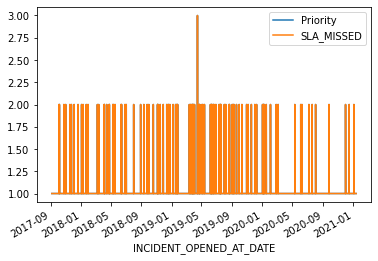

In [36]:
df[['INCIDENT_OPENED_AT_DATE','Priority','SLA_MISSED']].groupby(['INCIDENT_OPENED_AT_DATE']).count().plot()

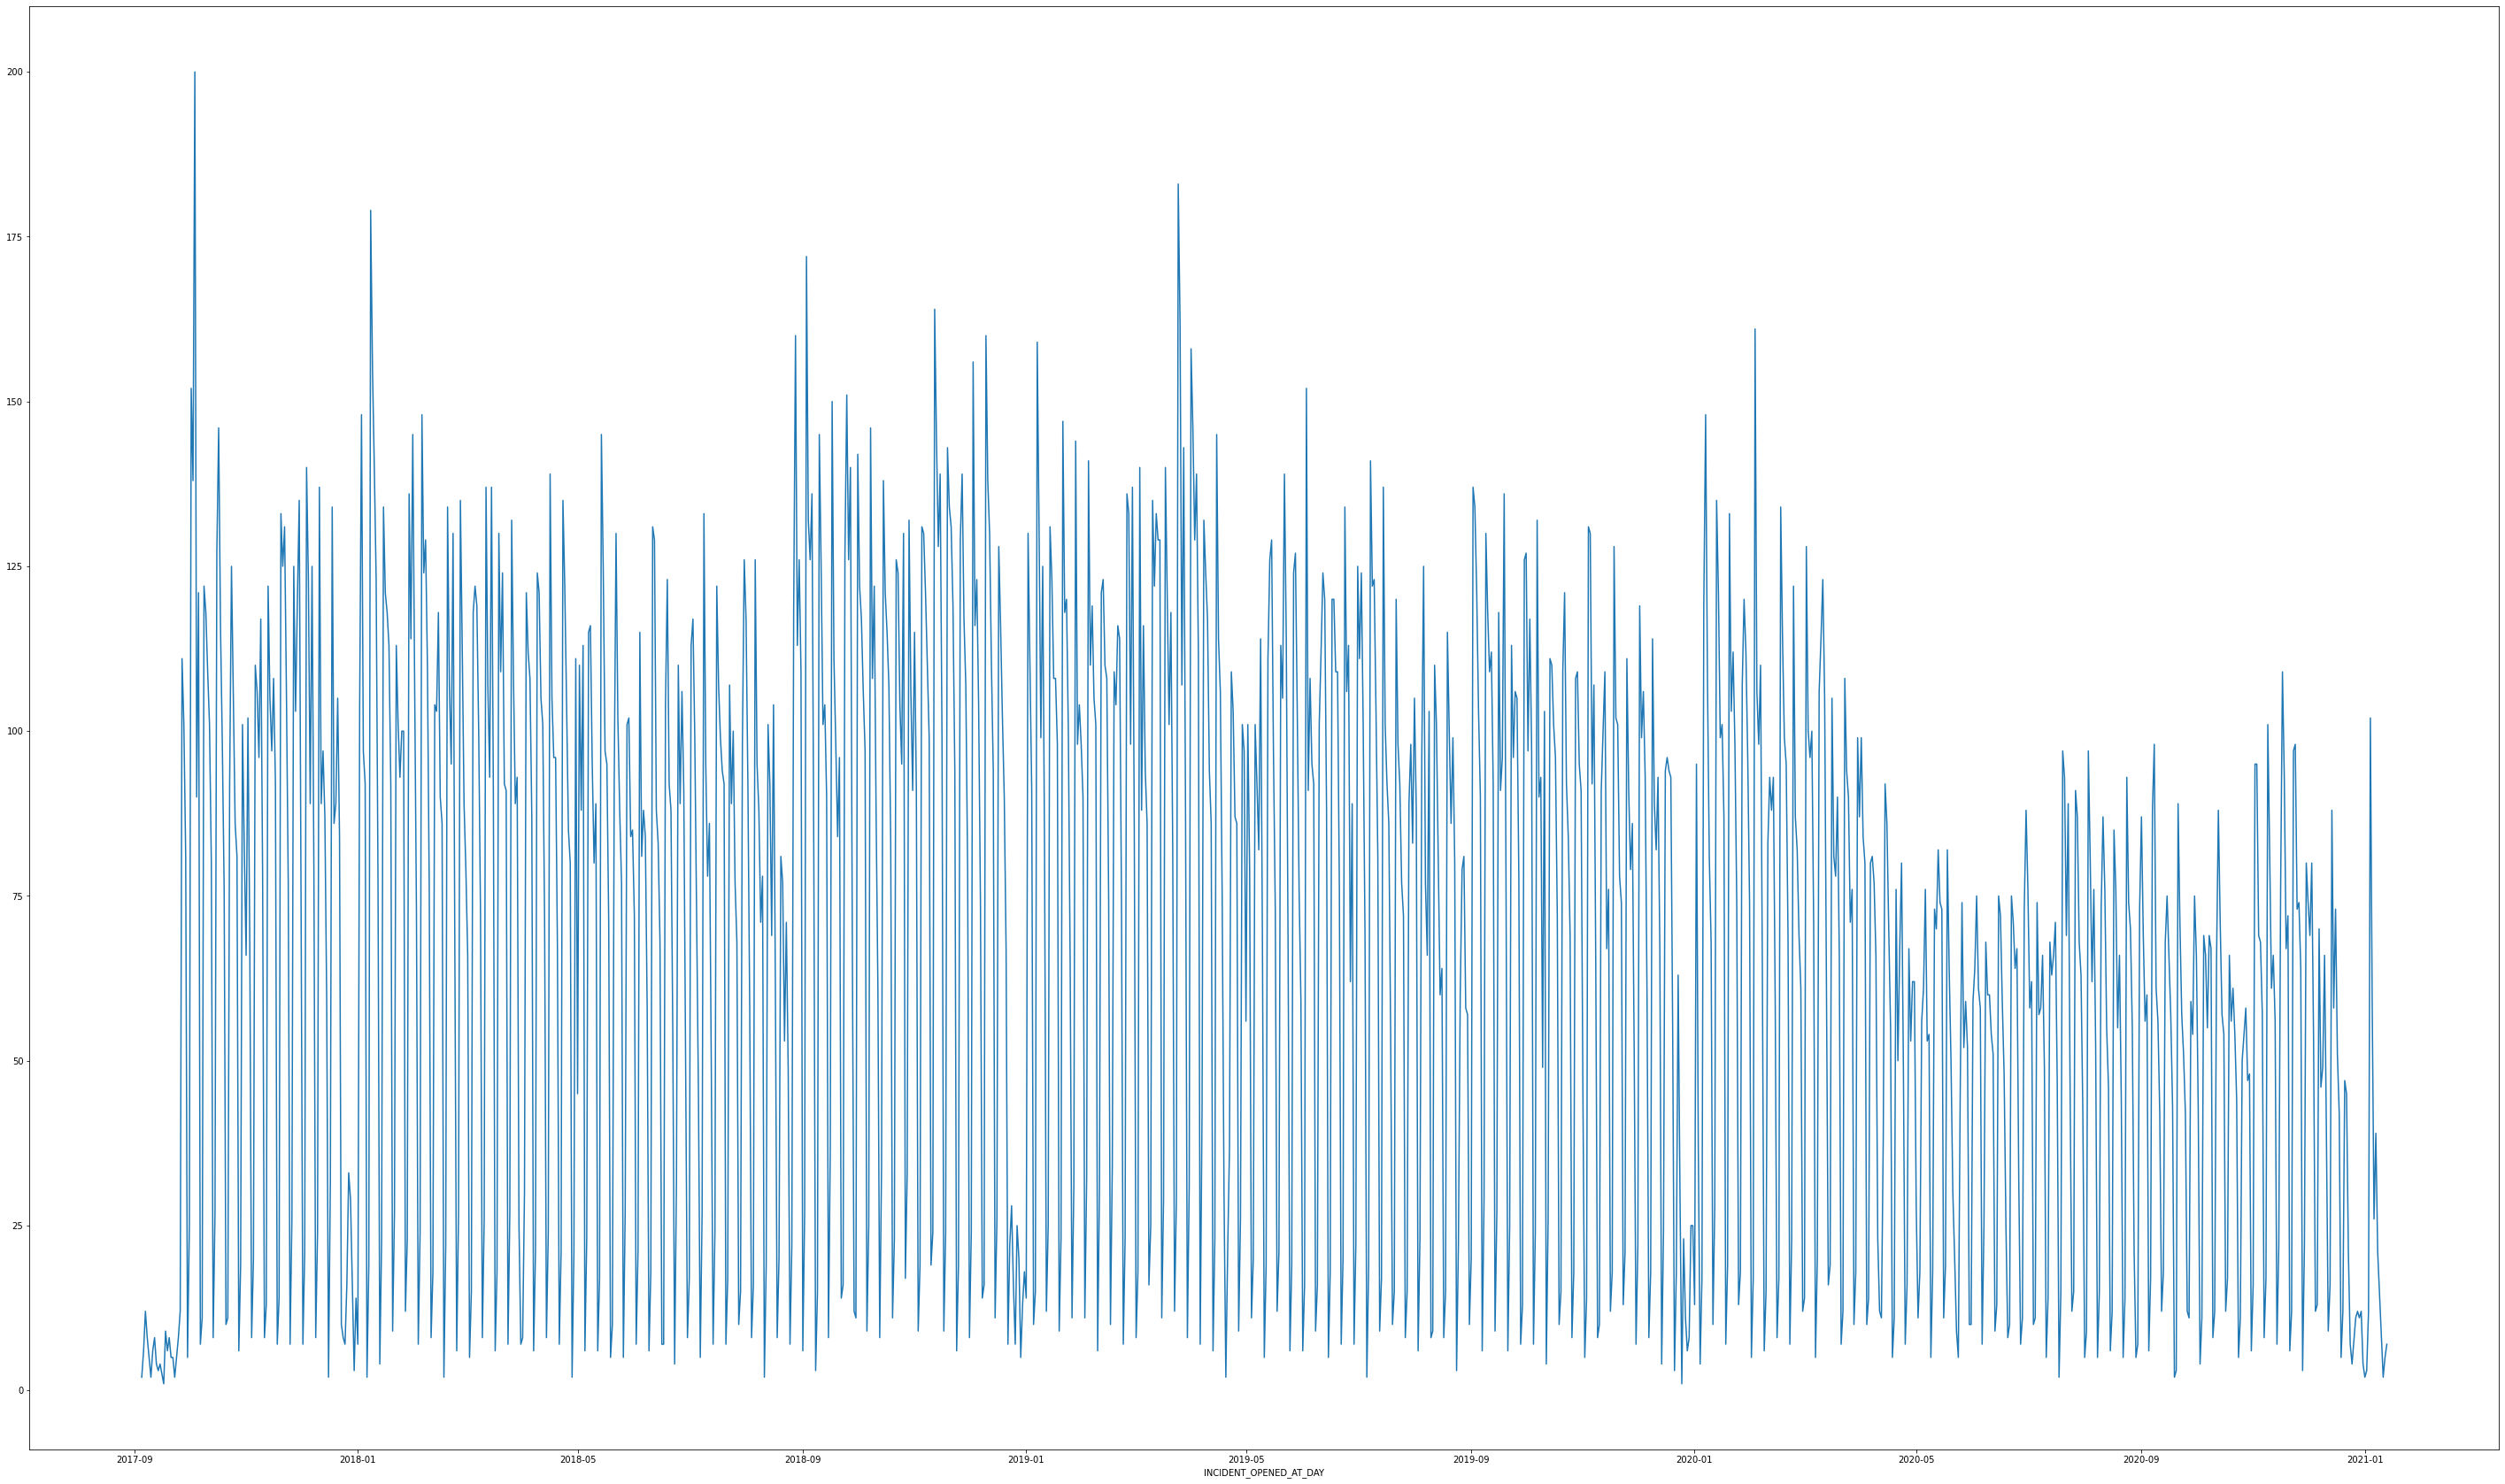

In [37]:
plt.figure(figsize = (50,30))
df[['INCIDENT_OPENED_AT_DAY','Priority','SLA_MISSED']].groupby(['INCIDENT_OPENED_AT_DAY']).size().plot()

In [38]:
df['SLA_MISSED'] = df['SLA_MISSED'].apply(lambda x: 1 if x == True else 0)

In [39]:
print(df['SLA_MISSED'].value_counts())

0    46288
1    37042
Name: SLA_MISSED, dtype: int64


In [40]:
df

,INCIDENT_NUMBER,INCIDENT_IMPACTED_USER,LABEL,ASSIGNEE_EMAIL,INCIDENT_SUMMARY,INCIDENT_NOTES,INCIDENT_STATE,IMPACTED_SERVICE,IMPACTED_SERVICE_OFFERING,ASSIGNMENT_GROUP,ASSIGNEMENT_SUPPORT_LEVEL,INCIDENT_CATEGORY,INCIDENT_SUBCATEGORY,FIRST_ASSIGNED_TIME,INCIDENT_OPENED_AT_DATE,INCIDENT_OPENED_FIS_MONTH,INCIDENT_OPENED_FIS_QUARTER,INCIDENT_OPENED_FIS_YEAR,INCIDENT_RESOLVED_AT_DATE,INCIDENT_CLOSED_AT_DATE,HR_COUNTRY,REGION,HR_THEATRE,DV_BUILDING,INCIDENT_RESOLVED_FIS_WEEK,INCIDENT_RESOLVED_FIS_MONTH,INCIDENT_RESOLVED_FIS_QUARTER,INCIDENT_RESOLVED_FIS_YEAR,INCIDENT_RESOLUTION_DOMAIN,INCIDENT_RESOLUTION_ACTION,INCIDENT_RESOLUTION_AREA,INCIDENT_RESOLUTION_NOTES,INCIDENT_IMPACTED_AREA,Priority,EXPECTED_SLA,RESOLUTION_TIME,SLA_MISSED,SLA_BREACHED_BY,INCIDENT_OPENED_AT_DAY
5,INC0047845,almikhli,Phone,sgundami@cisco.com,<<IPHONE>>,>>almikhli called in ESTS regarding ip phone i...,Closed,Collaboration Platform and Voice Services,IP Phone,TechSupport-Remote-T1,Tier 1,Performance,Function Not Working,10-Oct-17,2017-10-10 12:32:10,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,2017-10-10 12:56:29,2017-10-15 13:00:50,ISRAEL,EMEAR-SOUTH,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",NaN,FY2018 Q1 WK11,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,Service Request,NaN,NaN,>>resolved,NaN,5 - Standard,48,0.405278,0,NaN,2017-10-10
6,INC2077615,conradst,Email,mukhokha@cisco.com,BDLK10-1 App Dynamics Wireles Issues,Conrad Steven & others in the App Dynamics are...,Closed,Corporate Network,Secure LAN Access,Network-Ops-Premise,Tier 4,Performance,NaN,09-Dec-19,2019-12-09 14:34:15,FY2020 MON 05 (DEC),FY2020 Q2,FY2020,2019-12-15 12:00:11,2019-12-15 12:00:11,UNITED KINGDOM,UK and IRELAND,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",BEDFONT LAKES 10,FY2020 Q2 WK08,FY2020 MON 05 (DEC),FY2020 Q2,FY2020,Hardware,NaN,NaN,\nIncident 'INC2077615' closed based on closur...,Wireless - Connectivity Issue,5 - Standard,48,141.432222,1,93.432222,2019-12-09
10,INC0011890,lhegle,Phone,aperezro@cisco.com,lhegle@cisco.com // WebEx // WebEx recording p...,Incident Reported:\r\nName: Hegle Lee \r\nEmai...,Closed,Cloud Collaboration,Webex Meetings,RCSS,Tier 1,Performance,Degraded,13-Sep-17,2017-09-13 09:17:54,FY2018 MON 02 (SEP),FY2018 Q1,FY2018,2017-09-15 05:27:02,2017-09-20 06:00:02,GERMANY,EMEAR-CENTRAL,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",MUNICH - GARCHING,FY2018 Q1 WK07,FY2018 MON 02 (SEP),FY2018 Q1,FY2018,Service Request,NaN,NaN,Resolution Note:\r\n--------------------\r\n**...,Webex conferencing - mac,5 - Standard,48,44.152222,0,NaN,2017-09-13
22,INC0013843,amitron,Portal,rchiruma@cisco.com,access to Rally is so slow because of routing ...,Reach me by: Via Email\r\n\r\nI'm using the Ra...,Closed,Corporate Network,Cloud Port Service,NETWORK-OPS-CORE,Tier 1,Performance,Degraded,25-Oct-17,2017-09-27 07:09:29,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,2017-10-25 19:51:27,2017-10-30 20:00:26,ISRAEL,EMEAR-SOUTH,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",NaN,FY2018 Q1 WK13,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,Service Request,NaN,NaN,"This ticket is duplicate of INC0084310, closin...",NaN,5 - Standard,48,684.699444,1,636.699444,2017-09-27
31,INC0065009,gkalauz,Phone,ndevangm@cisco.com,>>Not able to log into the IP phone,>>called in ESTS regarding issue\r\n>>Callback...,Closed,Collaboration Platform and Voice Services,IP Phone & Features,TechSupport-Remote-EMEAR-T2-UC-Incident,Tier 2 - EMEAR,Performance,Function Not Working,17-Oct-17,2017-10-17 08:44:20,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,2017-10-17 11:13:27,2017-10-22 12:00:16,POLAND,EMEAR-CENTRAL,"EUROPE, MIDDLE EAST, AFRICA and RUSSIA",KRAKOW - ENTERPRISE PARK BLDG C,FY2018 Q1 WK12,FY2018 MON 03 (OCT),FY2018 Q1,FY2018,Service Request,NaN,NaN,Reactivated EM 1 secondary extension number,NaN,5 - Standard,48,2.485278,0,NaN,2017-10-17
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
84414,INC1435204,trimkus,Phone,kamalve@cisco.com,RTS>>UK NUMBER : +4

In [41]:
df['INCIDENT_RESOLUTION_DOMAIN'].value_counts()

Software               27683
Hardware               17086
Service/Process        11352
Service Request        10450
Data                    6867
Validation              6708
Training                2504
Job/Workflow             640
Service Catalog           32
Production Data Fix        5
Name: INCIDENT_RESOLUTION_DOMAIN, dtype: int64

In [42]:
df['INCIDENT_RESOLUTION_ACTION'].value_counts()

Configured                  32271
Manual Intervention         11503
Question Answered            9736
Installed New                7094
Re-Installed                 5078
No Further Action Taken      4156
Repaired Existing            2380
Training Needed              2114
Recreated                    1271
Customer Unreachable         1064
Restart                       932
Upgraded                      766
Withdrawn by Customer         751
Moved to Request Module       576
Third Party                   505
Removed                       476
Reboot                        475
External Status Provided      424
Applied Patch                 354
Test                          233
Business Process              219
Restored from Backup          216
Licensing / Certs             204
Policy                        165
Failed Over                   109
Restarted                      33
Missing Entry                  31
Cancelled                      28
Documentation Error             7
Manual        

In [43]:
df['Priority'].value_counts()

5 - Standard    80531
3 - Moderate     1468
4 - Minor        1223
1 - Critical       71
2 - High           37
Name: Priority, dtype: int64

## **Quarter-Wise Analysis**

In [44]:
quarter_incident_counts = df.groupby('INCIDENT_OPENED_FIS_QUARTER')['Priority'].value_counts().unstack().fillna(0)
quarter_incident_counts

Priority,1 - Critical,2 - High,3 - Moderate,4 - Minor,5 - Standard
INCIDENT_OPENED_FIS_QUARTER,,,,,
FY2018 Q1,2.0,4.0,36.0,8.0,2749.0
FY2018 Q2,9.0,4.0,19.0,4.0,6721.0
FY2018 Q3,6.0,2.0,22.0,17.0,7081.0
FY2018 Q4,7.0,1.0,48.0,59.0,6332.0
FY2019 Q1,9.0,7.0,71.0,141.0,7120.0
FY2019 Q2,7.0,1.0,78.0,116.0,7083.0
FY2019 Q3,14.0,6.0,76.0,85.0,7597.0
FY2019 Q4,1.0,1.0,55.0,82.0,6809.0
FY2020 Q1,6.0,1.0,224.0,130.0,6310.0


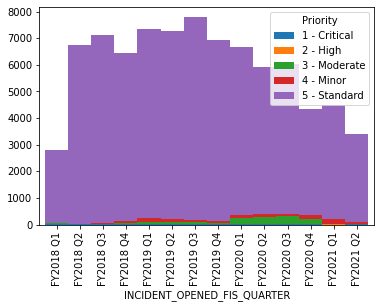

In [45]:
quarter_incident_counts = df.groupby('INCIDENT_OPENED_FIS_QUARTER')['Priority'].value_counts().unstack().fillna(0)
quarter_incident_counts.plot(kind = "bar", width = 1, stacked=True)

Text(0, 0.5, 'Number of Incidents')

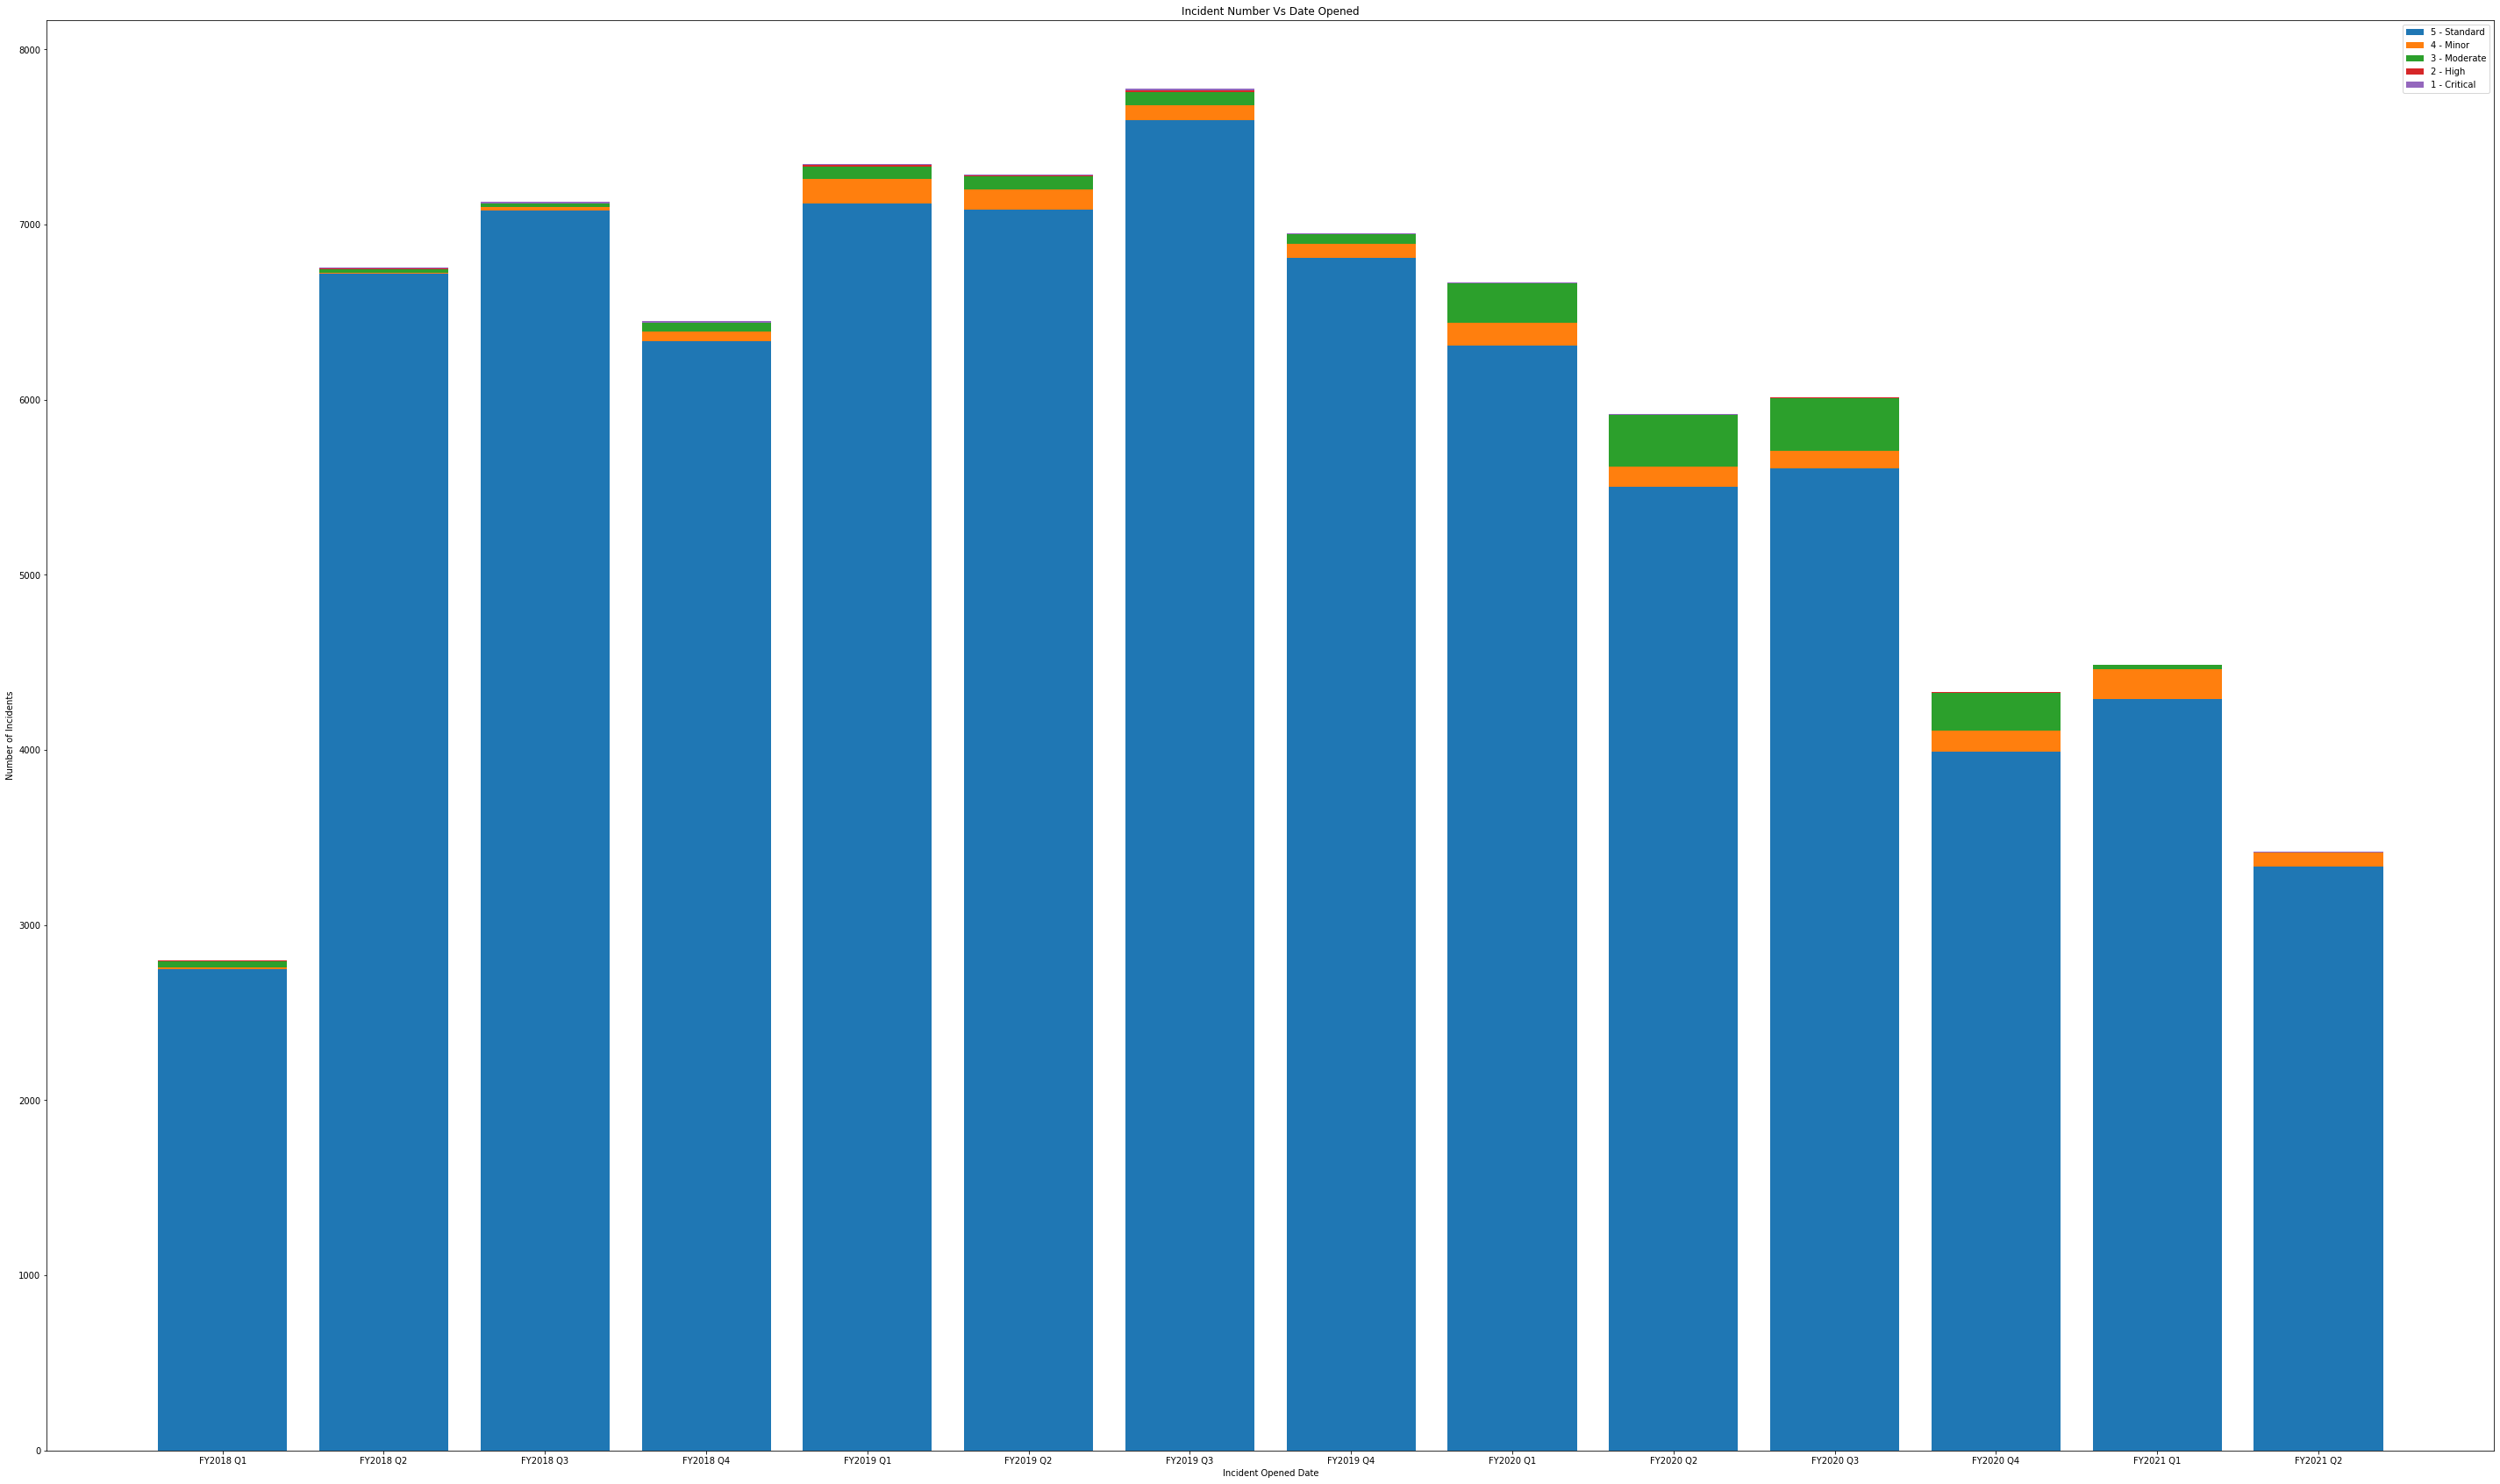

In [46]:
# Stacked bar graph using matplotlib
columns = list(quarter_incident_counts.columns)
columns.reverse()

fig = plt.figure(figsize = (50,30))
bottom = len(quarter_incident_counts) * [0]
for column in columns:
  plt.bar(quarter_incident_counts.index, quarter_incident_counts[column], bottom = bottom, label = column)
  bottom = bottom + quarter_incident_counts[column]

plt.legend()
plt.title('Incident Number Vs Date Opened')
plt.xlabel('Incident Opened Date')
plt.ylabel('Number of Incidents')

#### **Using plotly for stacked bar graphs**

***Priority***

*Number of cases:*
*   P4 Moderate cases reached peaks in FY2020, specifically Q2 and Q3 - why? That too Q2 includes shutdown.
*   FY2019 Q3 had the highest no. of P1 Critical cases and then Q4 had lowest - why the sharp decline?
*   P4 Minor cases reached a sharp peak in FY2021 Q1 whereas there were barely any cases in FY2018 Q2 and Q3 - Did definition of P4 change at some point?

P4 Q1 cases - look


*Missed SLAs:*
*   In general, missed SLA trends follow number of cases trends.
*   Missed SLAs for P5 Standard decreases over quarters from FY2019 Q3. - look at service contracts, talk to Ankit and Imran

*Fraction of missed SLAs:*
*   In general, for a given priority, the missed fraction changes only within a relatively small specific range - no sharp trends
*   P5 Critical cases have the lowest percentage of missed SLAs.






In [47]:
# Priority

# Number of cases
priority_quarterly_df = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'Priority']).size().reset_index(name="Count")

fig = px.bar(priority_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='Priority',
             title='Incident Count by Priority',
             width=1000, height=700) 
fig.show()

In [48]:
# Missed SLAs - Priority
priority_quarterly_df = df[df['SLA_MISSED'] == 1].groupby(['INCIDENT_OPENED_FIS_QUARTER', 'Priority']).size().reset_index(name="Count")

fig = px.bar(priority_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='Priority',
             title='Missed SLAs by Priority',
             width=1000, height=700) 
fig.show()

In [49]:
df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'Priority', 'SLA_MISSED']).size().reset_index(name="Count")

,INCIDENT_OPENED_FIS_QUARTER,Priority,SLA_MISSED,Count
0,FY2018 Q1,1 - Critical,1,2
1,FY2018 Q1,2 - High,0,3
2,FY2018 Q1,2 - High,1,1
3,FY2018 Q1,3 - Moderate,0,6
4,FY2018 Q1,3 - Moderate,1,30
...,...,...,...,...
112,FY2021 Q2,3 - Moderate,1,3
113,FY2021 Q2,4 - Minor,0,20
114,FY2021 Q2,4 - Minor,1,57
115,FY2021 Q2,5 - Standard,0,2085


In [50]:
df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'Priority'])['SLA_MISSED'].value_counts(normalize=True)

INCIDENT_OPENED_FIS_QUARTER  Priority      SLA_MISSED
FY2018 Q1                    1 - Critical  1             1.000000
                             2 - High      0             0.750000
                                           1             0.250000
                             3 - Moderate  1             0.833333
                                           0             0.166667
                                                           ...   
FY2021 Q2                    3 - Moderate  0             0.250000
                             4 - Minor     1             0.740260
                                           0             0.259740
                             5 - Standard  0             0.625187
                                           1             0.374813
Name: SLA_MISSED, Length: 117, dtype: float64

In [51]:
# To get the fraction of cases missed
df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'Priority'])['SLA_MISSED'].value_counts(normalize=True).reset_index(name = "Fraction_Missed")

,INCIDENT_OPENED_FIS_QUARTER,Priority,SLA_MISSED,Fraction_Missed
0,FY2018 Q1,1 - Critical,1,1.000000
1,FY2018 Q1,2 - High,0,0.750000
2,FY2018 Q1,2 - High,1,0.250000
3,FY2018 Q1,3 - Moderate,1,0.833333
4,FY2018 Q1,3 - Moderate,0,0.166667
...,...,...,...,...
112,FY2021 Q2,3 - Moderate,0,0.250000
113,FY2021 Q2,4 - Minor,1,0.740260
114,FY2021 Q2,4 - Minor,0,0.259740
115,FY2021 Q2,5 - Standard,0,0.625187


In [52]:
# Fraction of SLAs missed - Priority

# Retain only the fraction of cases missed
priority_quarterly_fraction = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'Priority'])['SLA_MISSED'].value_counts(normalize=True).reset_index(name = "Fraction_Missed")
priority_quarterly_fraction = priority_quarterly_fraction[priority_quarterly_fraction['SLA_MISSED'] == 1]
priority_quarterly_fraction

,INCIDENT_OPENED_FIS_QUARTER,Priority,SLA_MISSED,Fraction_Missed
0,FY2018 Q1,1 - Critical,1,1.000000
2,FY2018 Q1,2 - High,1,0.250000
3,FY2018 Q1,3 - Moderate,1,0.833333
5,FY2018 Q1,4 - Minor,1,0.875000
8,FY2018 Q1,5 - Standard,1,0.467806
...,...,...,...,...
109,FY2021 Q1,5 - Standard,1,0.380275
110,FY2021 Q2,1 - Critical,1,1.000000
111,FY2021 Q2,3 - Moderate,1,0.750000
113,FY2021 Q2,4 - Minor,1,0.740260


In [53]:
fig = px.bar(priority_quarterly_fraction, x="INCIDENT_OPENED_FIS_QUARTER", y="Fraction_Missed", color='Priority',
             title='Fraction of SLAs Missed by Priority',
             width=1000, height=600) 
#fig.update_xaxes(matches=None, showticklabels=True, visible=True)
fig.show()

***Incident Category***

*Number of cases:*
*   Error category follows a wave then dips
*   Access issues have declined over the quarters
*   More than 650 cases of Performance issues in FY2019 Q3 - FY2020 Q4
*   Service Request cases were lowest in FY2018 and increased to 2.5x in early FY2020 - change in definition?
*   Service/Process issues peak in FY2019 Q2

<br>
Do missed SLAs follow the same trend?

*Missed SLAs:*
*   In general, for a given incident category, the missed fraction changes only within a relatively small specific range - no sharp trends
*   Missed SLAs for Performance issues peak in FY2020 Q2 and then decline
*   Missed SLAs for Service Request issues peak sharply in FY2019 Q3 and then decline - means fraction of missed SLAs must change too since total number of cases are comparatively similar in FY2019 Q3 - FY2020
*   

*Fraction of Missed SLAs:*
*   Performance issues and Service/Process show the most variation in fraction followed by Service Request category and 

Based on these observations, it might be worth analysing Performance and Service Request Incident Categories on a deeper level.



In [54]:
#Incident Category

# Number of cases

incident_category_quarterly_df = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'INCIDENT_CATEGORY']).size().reset_index(name="Count")
incident_category_quarterly_df

,INCIDENT_OPENED_FIS_QUARTER,INCIDENT_CATEGORY,Count
0,FY2018 Q1,Access,738
1,FY2018 Q1,Error,916
2,FY2018 Q1,Performance,373
3,FY2018 Q1,Service Request,289
4,FY2018 Q1,Service/Process,483
...,...,...,...
65,FY2021 Q2,Access,686
66,FY2021 Q2,Error,775
67,FY2021 Q2,Performance,392
68,FY2021 Q2,Service Request,1327


In [55]:
fig = px.bar(incident_category_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='INCIDENT_CATEGORY',
             title='Incident Count by Incident Category',
             width=1000, height=600) 
#fig.update_xaxes(matches=None, showticklabels=True, visible=True)
fig.show()

In [56]:
# Missed SLAs - Incident Category

# Number of cases
incident_category_quarterly_df = df[df['SLA_MISSED'] == 1].groupby(['INCIDENT_OPENED_FIS_QUARTER', 'INCIDENT_CATEGORY']).size().reset_index(name="Count")
fig = px.bar(incident_category_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='INCIDENT_CATEGORY',
             title='Missed SLAs by Incident Category',
             width=1000, height=600) 
#fig.update_xaxes(matches=None, showticklabels=True, visible=True)
fig.show()

In [57]:
# Fraction of SLAs Missed - Incident Category

# Retain only the fraction of cases missed
incident_category_quarterly_fraction = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'INCIDENT_CATEGORY'])['SLA_MISSED'].value_counts(normalize=True).reset_index(name = "Fraction_Missed")
incident_category_quarterly_fraction = incident_category_quarterly_fraction[incident_category_quarterly_fraction['SLA_MISSED'] == 1]
incident_category_quarterly_fraction

fig = px.bar(incident_category_quarterly_fraction, x="INCIDENT_OPENED_FIS_QUARTER", y="Fraction_Missed", color='INCIDENT_CATEGORY',
             title='Fraction of SLAs Missed by Incident Category',
             width=1000, height=600) 
#fig.update_xaxes(matches=None, showticklabels=True, visible=True)
fig.show()

***Impacted Service***

*Number of cases:*
*   Cloud Collaboration generally peaks in Q3. But also in FY2019 Q1 and Q2
*   Collaboration Platform and Voice Services - higher in odd quarters and lower in subsequent even quarter. Why?
*   Corporate Network peaked in FY2019 Q4 and declines steadily thereafter - not a coincidence?
*   List item
*   Expense management peaked in FY2019 Q2 - why?
*   End User Computing cases declined from FY2020 Q2 
*   Expense Management - Cases steadily increase up until FY2019 Q1, peak in Q2 and then steadily decreases.
*   Identity and Access - Case counts are highly variable, missed SLAs and fractions too
*   Video collaboration - almost steadily declined over quarters with fraction of SLAs missed following an irregular trend


<br>
Do missed SLAs follow the same trend?

*Missed SLAs:*
*   End User Computing - Remains constant after FY2019 Q4
*   Generally follows no. of cases trends

*Fraction of Missed SLAs:*
*   Identity and Access for Workforce has the lowest fraction of missed SLAs (probably averages at 0.2). Followed by Cloud Collaboration and End User Computing.
*   High variation in fraction - Identity and Access, Expense Management, End User Computing, 
*   End User Computing - Fraction increases over quarters in a financial year
*   

So look into Identity and Access?


In [58]:
# Impacted Service

# Number of cases
impacted_service_quarterly_df = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'IMPACTED_SERVICE']).size().reset_index(name="Count")

fig = px.bar(impacted_service_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='IMPACTED_SERVICE',
             title='Incident Count by Impacted Service',
             width=1200, height=600) 
fig.show()

In [59]:
# Missed SLAs - Impacted Service

impacted_service_quarterly_df = df[df['SLA_MISSED'] == 1].groupby(['INCIDENT_OPENED_FIS_QUARTER', 'IMPACTED_SERVICE']).size().reset_index(name="Count")

fig = px.bar(impacted_service_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='IMPACTED_SERVICE',
             title='Missed SLAs by Impacted Service',
             width=1200, height=600) 
fig.show()

In [60]:
# Fraction of SLAs Missed - Impacted Service

# Retain only the fraction of cases missed
impacted_service_quarterly_fraction = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'IMPACTED_SERVICE'])['SLA_MISSED'].value_counts(normalize=True).reset_index(name = "Fraction_Missed")
impacted_service_quarterly_fraction = impacted_service_quarterly_fraction[impacted_service_quarterly_fraction['SLA_MISSED'] == 1]
impacted_service_quarterly_fraction

fig = px.bar(impacted_service_quarterly_fraction, x="INCIDENT_OPENED_FIS_QUARTER", y="Fraction_Missed", color='IMPACTED_SERVICE',
             title='Fraction of SLAs Missed by Impacted Service',
             width=1200, height=600) 
#fig.update_xaxes(matches=None, showticklabels=True, visible=True)
fig.show()

***Region***

*Number of Cases:*
*   Emerging Region's cases sharply shot up from FY2019 Q4 - Why? Were more areas added to the region?
> Is it related to EMEAR-Emerging? What is the difference between the two? EMEAR-Emerging has no data after FY2019 Q3
*   EMEAR Central - cases peak in Q3 and are lower in Q2 and Q4
*   EMEAR North - cases reduce over quarters in a year, but missed SLAs don't follow exactly the same pattern
*   EMEAR South - ??
*   UK & Ireland - Alternates quarter-wise until FY2019 Q3 and then declines - not sure whether worth pursuing

*Missed SLAs:*
*   EMEAR South - Missed SLAs highest in FY2019

*Fraction of SLAs Missed:*
*   UK and Ireland cases dropped starting with FY2020 Q4 - Why?
*   EMEAR Central, EMEAR South - unsure about the trend, seems wave-like - look at monthly or weekly trends instead.








In [61]:
# Region

# Number of cases
region_quarterly_df = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'REGION']).size().reset_index(name="Count")

fig = px.bar(region_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='REGION',
             title='Incident Count by Region',
             width=1200, height=600)
fig.show()

In [62]:
# Missed SLAs - Region

region_quarterly_df = df[df['SLA_MISSED'] == 1].groupby(['INCIDENT_OPENED_FIS_QUARTER', 'REGION']).size().reset_index(name="Count")

fig = px.bar(region_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='REGION',
             title='Missed SLAs by Region',
             width=1200, height=600)
fig.show()

In [63]:
# Fraction of SLAs Missed - Region

# Retain only the fraction of cases missed
region_quarterly_fraction = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'REGION'])['SLA_MISSED'].value_counts(normalize=True).reset_index(name = "Fraction_Missed")
region_quarterly_fraction = region_quarterly_fraction[region_quarterly_fraction['SLA_MISSED'] == 1]
region_quarterly_fraction

fig = px.bar(region_quarterly_fraction, x="INCIDENT_OPENED_FIS_QUARTER", y="Fraction_Missed", color='REGION',
             title='Fraction of SLAs Missed by Region',
             width=1000, height=600) 
#fig.update_xaxes(matches=None, showticklabels=True, visible=True)
fig.show()

In [64]:
# Incident Subcategory

#Number of cases
region_quarterly_df = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'INCIDENT_SUBCATEGORY']).size().reset_index(name="Count")

fig = px.bar(region_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='INCIDENT_SUBCATEGORY',
             title='Incident Count by Incident Subcategory',
             width=1200, height=800) 
fig.show()

In [65]:
# Impacted Service Offering

region_quarterly_df = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'IMPACTED_SERVICE_OFFERING']).size().reset_index(name="Count")

fig = px.bar(region_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='IMPACTED_SERVICE_OFFERING',
             title='Incident Count by Impacted Service Offering')
            #  width=1200, height=1000) 
fig.show()

In [66]:
# Assignment Group
country_quarterly_df = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'ASSIGNMENT_GROUP']).size().reset_index(name="Count")

fig = px.bar(country_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='ASSIGNMENT_GROUP',
             title='Incident Count by Assignment Group',
             width=1200, height=900) 
fig.show()

In [67]:
# HR Country
country_quarterly_df = df.groupby(['INCIDENT_OPENED_FIS_QUARTER', 'HR_COUNTRY']).size().reset_index(name="Count")

fig = px.bar(country_quarterly_df, x="INCIDENT_OPENED_FIS_QUARTER", y="Count", color='HR_COUNTRY',
             title='Incident Count by HR Country',
             width=1200, height=900) 
fig.show()

## **Month-Wise Analysis**

In [68]:
trial = df.groupby(['INCIDENT_OPENED_AT_DATE', 'Priority']).size().reset_index(name="Count")
trial

,INCIDENT_OPENED_AT_DATE,Priority,Count
0,2017-09-05 13:47:54,5 - Standard,1
1,2017-09-05 16:28:02,5 - Standard,1
2,2017-09-06 09:45:52,5 - Standard,1
3,2017-09-06 13:37:30,5 - Standard,1
4,2017-09-06 15:11:33,5 - Standard,1
...,...,...,...
83213,2021-01-13 13:00:45,5 - Standard,1
83214,2021-01-13 13:19:36,5 - Standard,1
83215,2021-01-13 14:01:22,5 - Standard,1
83216,2021-01-13 15:54:53,5 - Standard,1


In [69]:
trial.index

RangeIndex(start=0, stop=83218, step=1)

In [70]:
trial.resample('M', on = 'INCIDENT_OPENED_AT_DATE')

In [71]:
# Check total number of records for month of September 2017
# len(df[df['INCIDENT_OPENED_AT_DATE'] == datetime.date(datetime.strptime('2017-09-30', "%Y-%m-%d"))])
len(df[(pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).month == 9) & (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2017)])

# Alt way of extracting month:
# pd.to_datetime(df['INCIDENT_OPENED_AT_DATE']).dt.month 

409

In [72]:
# Monthly case numbers

monthly_counts = df.groupby(['INCIDENT_OPENED_AT_DATE']).size().reset_index(name="Count")
monthly_counts = monthly_counts.resample('M', on = 'INCIDENT_OPENED_AT_DATE').sum().reset_index()
monthly_counts

,INCIDENT_OPENED_AT_DATE,Count
0,2017-09-30,409
1,2017-10-31,2590
2,2017-11-30,2425
3,2017-12-31,1827
4,2018-01-31,2722
5,2018-02-28,2251
6,2018-03-31,2353
7,2018-04-30,2238
8,2018-05-31,2344
9,2018-06-30,2014


In [73]:
fig = px.bar(monthly_counts, x="INCIDENT_OPENED_AT_DATE", y="Count",
             title='Number of Incidents over Months',
             width=1200, height=900) 
fig.show()

In [74]:
monthly_counts = monthly_counts.set_index('INCIDENT_OPENED_AT_DATE')
monthly_counts

,Count
INCIDENT_OPENED_AT_DATE,
2017-09-30,409
2017-10-31,2590
2017-11-30,2425
2017-12-31,1827
2018-01-31,2722
2018-02-28,2251
2018-03-31,2353
2018-04-30,2238
2018-05-31,2344


Following this article: https://machinelearningmastery.com/time-series-data-visualization-with-python for the next 6 types of plots

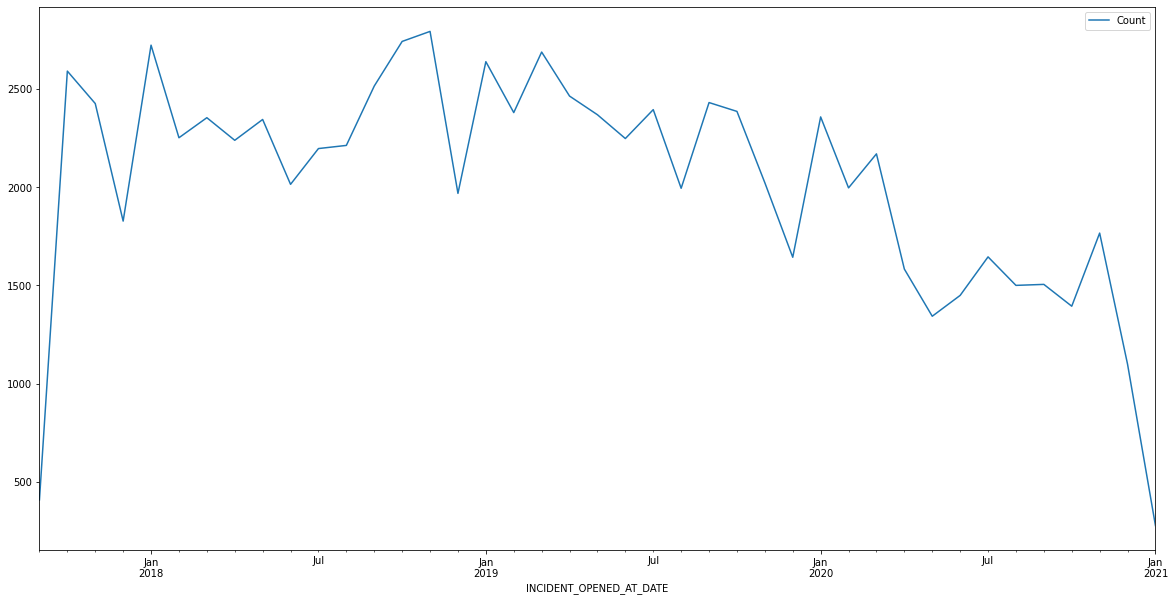

In [75]:
# Line plot
# plt.figure(figsize=(15,15))
monthly_counts.plot(figsize=(20, 10))

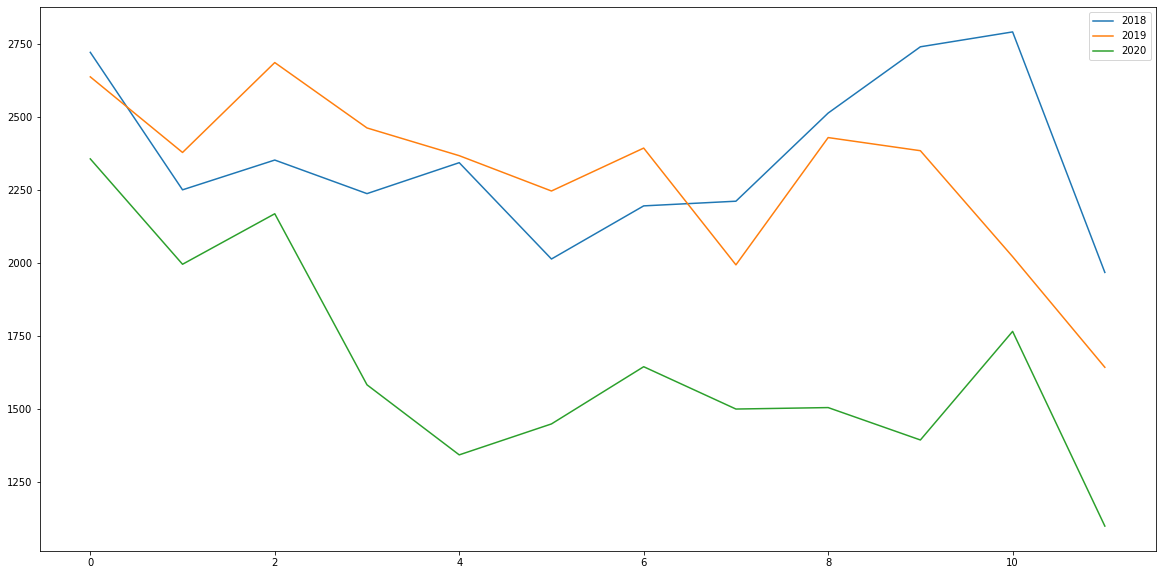

In [76]:
# Plotting over months across years 2018, 2019, 2020 in dataset
selected_years_df = df[(pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2018) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2019) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2020)]
selected_years_df = selected_years_df.groupby('INCIDENT_OPENED_AT_DATE').size()

selected_years_df = selected_years_df.resample('M').sum()

groups = selected_years_df.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  # print(group.values)
  years[name.year] = group.values
years.plot(figsize=(20, 10))
# plt.show()

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f988320d0>,
      dtype=object)

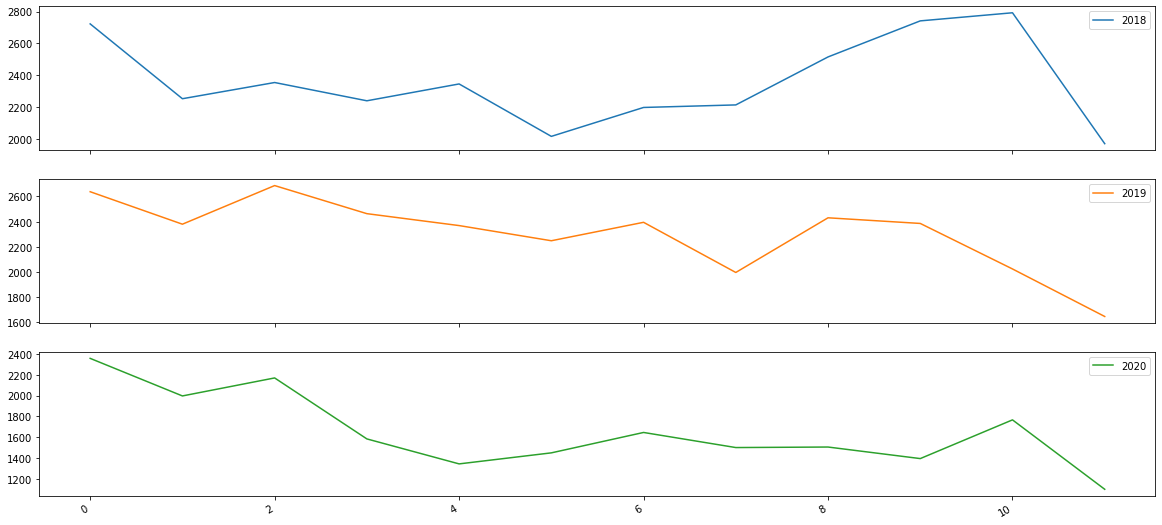

In [77]:
# With sub plots instead
years.plot(subplots = True, legend = True, figsize=(20, 10))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f983f4410>]],
      dtype=object)

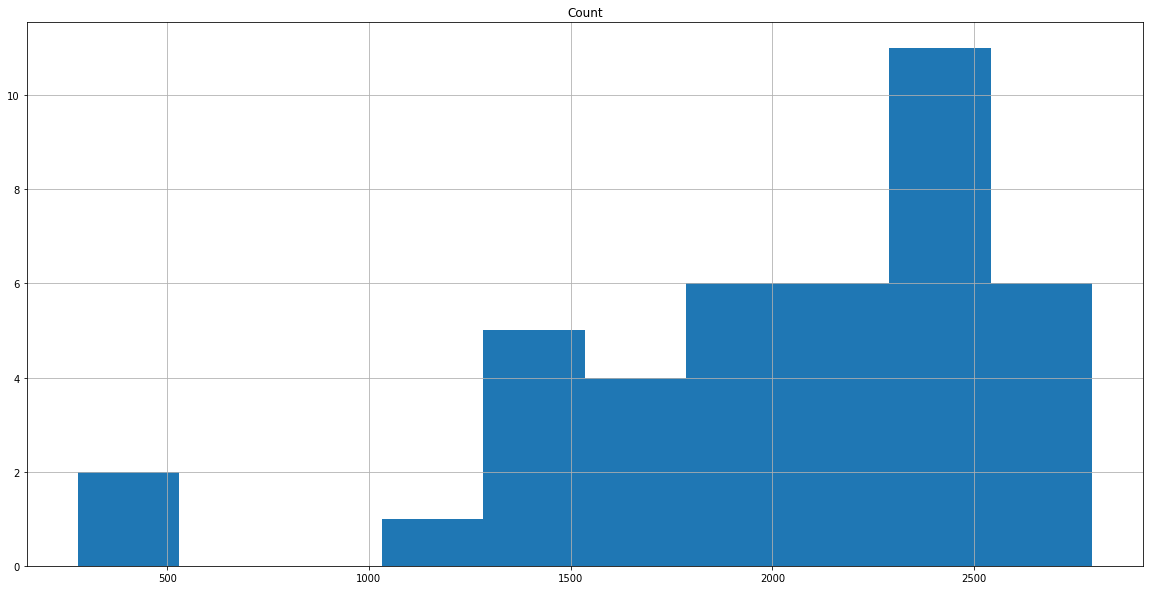

In [78]:
# Histogram - of monthly case counts in the data - pretty useless
monthly_counts.hist(figsize=(20, 10))
# So the data is not normally distributed


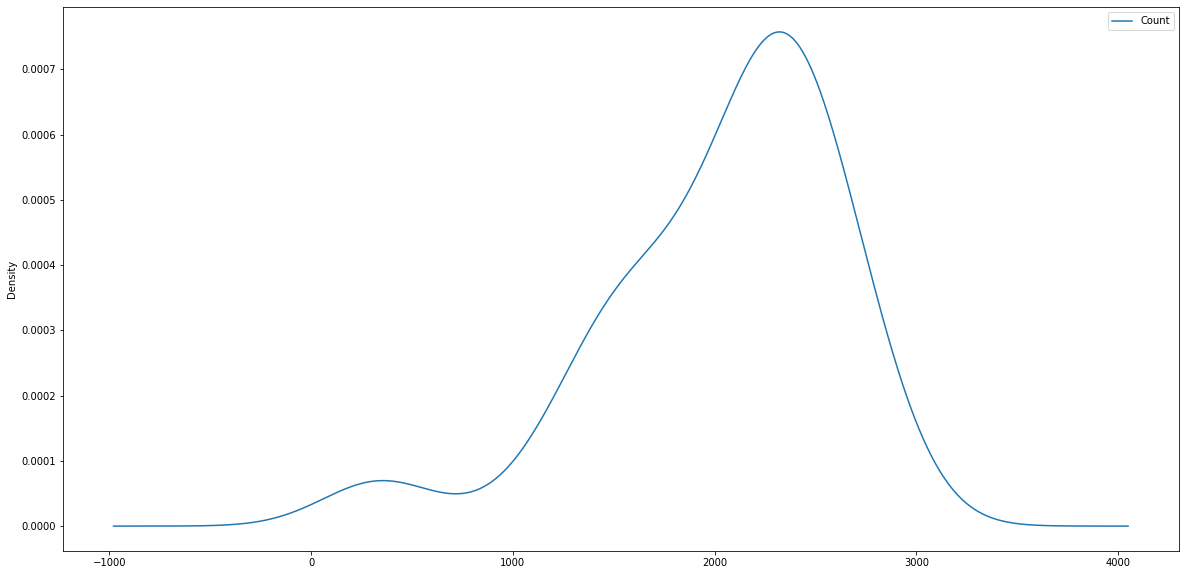

In [79]:
# Density Plot - Also useless for us?
monthly_counts.plot(kind='kde', figsize=(20, 10))

So obviously December has the lowest median number of cases in a day. And February has the highest?
<br>
<font color = '#ee555f'>The method followed to get dataframe after grouping here is different from the previous because otherwise array sizes won't match for months that have different no. of days</font>

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



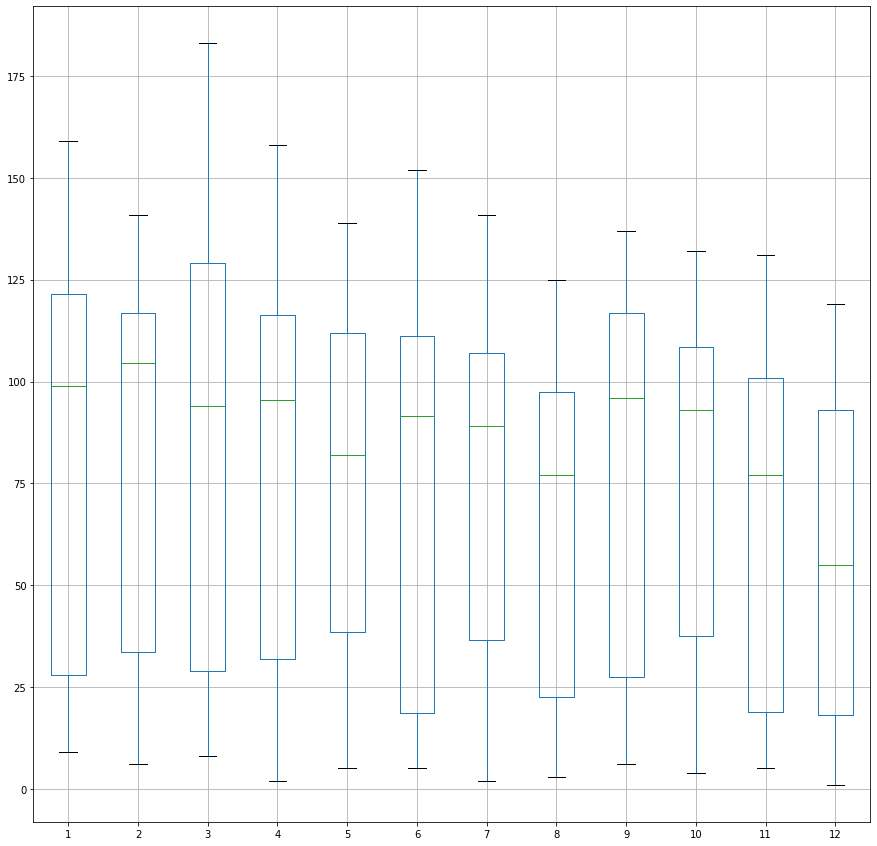

In [80]:
# Time Series Box and Whisker Plot by Time Interval
# Histograms and density plots provide insight into the distribution of all observations, but we may be interested in the distribution of values by time interval.

# Distribution of values across months within a year - 2019
monthly_counts_2019 = df[pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2019]
monthly_counts_2019 = monthly_counts_2019.groupby('INCIDENT_OPENED_AT_DATE').size()

# First resample at least by day so that counts aren't just 1 second-wise
monthly_counts_2019 = monthly_counts_2019.resample('D').sum()
groups = monthly_counts_2019.groupby(pd.Grouper(freq='M'))

# for x in groups:
#   print(x[1])
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
# months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot(figsize=(15,15))
plt.show()

Does this give us any useful insights?

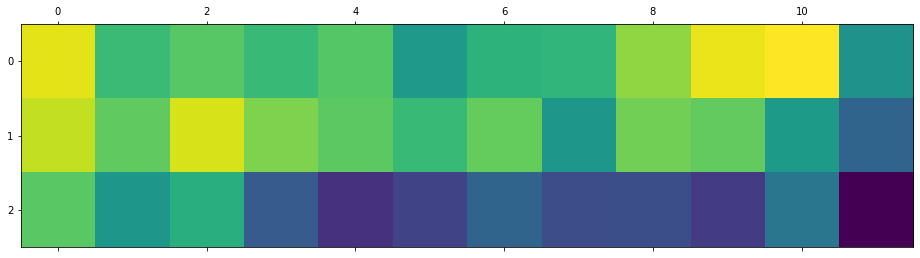

In [81]:
# Time Series Heat Maps
# A matrix of numbers can be plotted as a surface, where the values in each cell of the matrix are assigned a unique color.
# This is called a heatmap, as larger values can be drawn with warmer colors (yellows and reds) and smaller values can be drawn with cooler colors (blues and greens).

selected_years_df = df[(pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2018) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2019) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2020)]
selected_years_df = selected_years_df.groupby('INCIDENT_OPENED_AT_DATE').size()

selected_years_df = selected_years_df.resample('M').sum()

groups = selected_years_df.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
	years[name.year] = group.values
years = years.T
plt.matshow(years, interpolation=None, aspect='auto')
plt.show()

# For convenience, the matrix is rotation (transposed) so that each row represents one year and each column one day. This provides a more intuitive, left-to-right layout of the data.
# So rows 0, 1 and 2 are years 2018, 2019 and 2020


'\nIf the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.\nIf the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.\nEither relationship is good as they can be modeled.\nMore points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship.\n\nA ball in the middle or a spread across the plot suggests a weak or no relationship.\n'

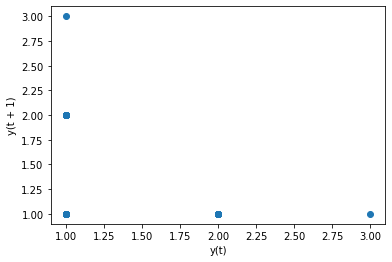

In [82]:
# Time Series Lag Scatter Plots

'''
Time series modeling assumes a relationship between an observation and the previous observation.
Previous observations in a time series are called lags, with the observation at the previous time step called lag1, the observation at two time steps ago lag2, and so on.
A useful type of plot to explore the relationship between each observation and a lag of that observation is called the scatter plot.

Pandas has a built-in function for exactly this called the lag plot. It plots the observation at time t on the x-axis and the lag1 observation (t-1) on the y-axis.
from pandas.plotting import lag_plot
'''
from pandas.plotting import lag_plot

day_grouped_counts = df.groupby('INCIDENT_OPENED_AT_DATE').size()
lag_plot(day_grouped_counts)

'''
If the points cluster along a diagonal line from the bottom-left to the top-right of the plot, it suggests a positive correlation relationship.
If the points cluster along a diagonal line from the top-left to the bottom-right, it suggests a negative correlation relationship.
Either relationship is good as they can be modeled.
More points tighter in to the diagonal line suggests a stronger relationship and more spread from the line suggests a weaker relationship.

A ball in the middle or a spread across the plot suggests a weak or no relationship.
'''

<font color='#ee555e'>What sort of relationship is this?</font> Can we even expect a relationship with such data?

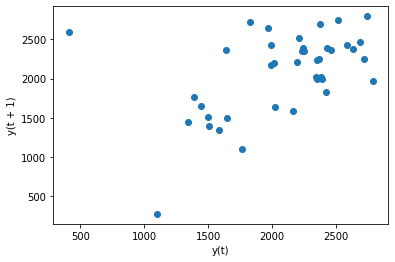

In [83]:
month_resampled_counts = day_grouped_counts.resample('M').sum()
lag_plot(month_resampled_counts)

<font color='#ee555e'>So none of our correlation values are statistically significant according to our dotted lines?</font>

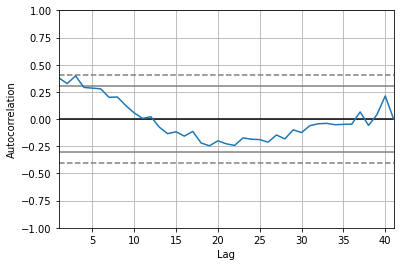

In [84]:
# Time Series Autocorrelation Plots

'''
We can quantify the strength and type of relationship between observations and their lags. In statistics, this is called correlation, and when calculated against lag values in time series, it is called autocorrelation (self-correlation).
A correlation value calculated between two groups of numbers, such as observations and their lag1 values, results in a number between -1 and 1. The sign of this number indicates a negative or positive correlation respectively. A value close to zero suggests a weak correlation, whereas a value closer to -1 or 1 indicates a strong correlation.
Correlation values, called correlation coefficients, can be calculated for each observation and different lag values. Once calculated, a plot can be created to help better understand how this relationship changes over the lag.
This type of plot is called an autocorrelation plot and Pandas provides this capability built in, called the autocorrelation_plot() function.
'''
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(month_resampled_counts)

# Dotted lines are provided that indicate any correlation values above those lines are statistically significant (meaningful).
#  If you get cycles of strong negative and positive correlation, it captures the relationship of an observation with past observations in the same and opposite seasons or times of year. Sine waves are a strong sign of seasonality in the dataset.



Variation over months in a year

In [85]:
# Plot data only for months in 2020
start, end = '2020-01-31', '2020-12-31'

counts_2020 = df.groupby(['INCIDENT_OPENED_AT_DATE']).size()
counts_2020 = counts_2020.resample('M').sum()
counts_2020 = counts_2020.loc[start: end]
counts_2020 = counts_2020.reset_index(name='Count')

In [86]:
fig = px.bar(counts_2020, x="INCIDENT_OPENED_AT_DATE", y="Count",
             title='Number of Incidents over Months in 2020',
             width=1200, height=900) 
fig.show()

**Resampling monthly with groupby for various categories**

Priority

In [87]:
df.groupby(['Priority', pd.Grouper(freq='M', key='INCIDENT_OPENED_AT_DATE')]).size()

Priority      INCIDENT_OPENED_AT_DATE
1 - Critical  2017-10-31                    2
              2017-11-30                    4
              2017-12-31                    3
              2018-01-31                    4
              2018-02-28                    3
                                         ... 
5 - Standard  2020-09-30                 1430
              2020-10-31                 1345
              2020-11-30                 1726
              2020-12-31                 1068
              2021-01-31                  277
Length: 169, dtype: int64

In [88]:
#Priority

priority_monthly_df = df.groupby([pd.Grouper(freq='M', key='INCIDENT_OPENED_AT_DATE'), 'Priority']).size()
priority_monthly_df

INCIDENT_OPENED_AT_DATE  Priority    
2017-09-30               2 - High           2
                         3 - Moderate      14
                         4 - Minor          1
                         5 - Standard     392
2017-10-31               1 - Critical       2
                                         ... 
2020-12-31               1 - Critical       1
                         4 - Minor         30
                         5 - Standard    1068
2021-01-31               4 - Minor          1
                         5 - Standard     277
Length: 169, dtype: int64

In [89]:
priority_monthly_df = priority_monthly_df.reset_index(name = "Count")
priority_monthly_df

,INCIDENT_OPENED_AT_DATE,Priority,Count
0,2017-09-30,2 - High,2
1,2017-09-30,3 - Moderate,14
2,2017-09-30,4 - Minor,1
3,2017-09-30,5 - Standard,392
4,2017-10-31,1 - Critical,2
...,...,...,...
164,2020-12-31,1 - Critical,1
165,2020-12-31,4 - Minor,30
166,2020-12-31,5 - Standard,1068
167,2021-01-31,4 - Minor,1


In [90]:
fig = px.bar(priority_monthly_df, x="INCIDENT_OPENED_AT_DATE", y="Count", color="Priority",
             title='Monthly Incident Count by Priority',
             width=1200, height=900) 
fig.show()

In [91]:
# Impacted Service

impacted_service_monthly_df = df.groupby([pd.Grouper(freq='M', key='INCIDENT_OPENED_AT_DATE'), 'IMPACTED_SERVICE']).size().reset_index(name = "Count")

fig = px.bar(impacted_service_monthly_df, x="INCIDENT_OPENED_AT_DATE", y="Count", color="IMPACTED_SERVICE",
             title='Monthly Incident Count by Impacted Service',
             width=1800, height=900) 
fig.show()

In [92]:
# Incident Category

incident_category_monthly_df = df.groupby([pd.Grouper(freq='M', key='INCIDENT_OPENED_AT_DATE'), 'INCIDENT_CATEGORY']).size().reset_index(name = "Count")

fig = px.bar(incident_category_monthly_df, x="INCIDENT_OPENED_AT_DATE", y="Count", color="INCIDENT_CATEGORY",
             title='Monthly Incident Count by Incident Category',
             width=1600, height=1000) 
fig.show()

In [93]:
# Region

region_monthly_df = df.groupby([pd.Grouper(freq='M', key='INCIDENT_OPENED_AT_DATE'), 'REGION']).size().reset_index(name = "Count")

fig = px.bar(region_monthly_df, x="INCIDENT_OPENED_AT_DATE", y="Count", color="REGION",
             title='Monthly Incident Count by Region',
             width=1600, height=1000) 
fig.show()

## **Week-Wise Analysis**

In [94]:
# Weekly case numbers

weekly_counts = df.groupby(['INCIDENT_OPENED_AT_DATE']).size().reset_index(name="Count")
weekly_counts = weekly_counts.resample('W', on = 'INCIDENT_OPENED_AT_DATE').sum().reset_index()
print(weekly_counts)

fig = px.line(weekly_counts, x="INCIDENT_OPENED_AT_DATE", y="Count",
             title='Number of weekly incidents',
             width=1200, height=900) 
fig.show()

    INCIDENT_OPENED_AT_DATE  Count
0                2017-09-10     30
1                2017-09-17     26
2                2017-09-24     35
3                2017-10-01    343
4                2017-10-08    719
..                      ...    ...
171              2020-12-20    329
172              2020-12-27    135
173              2021-01-03     56
174              2021-01-10    247
175              2021-01-17     14

[176 rows x 2 columns]


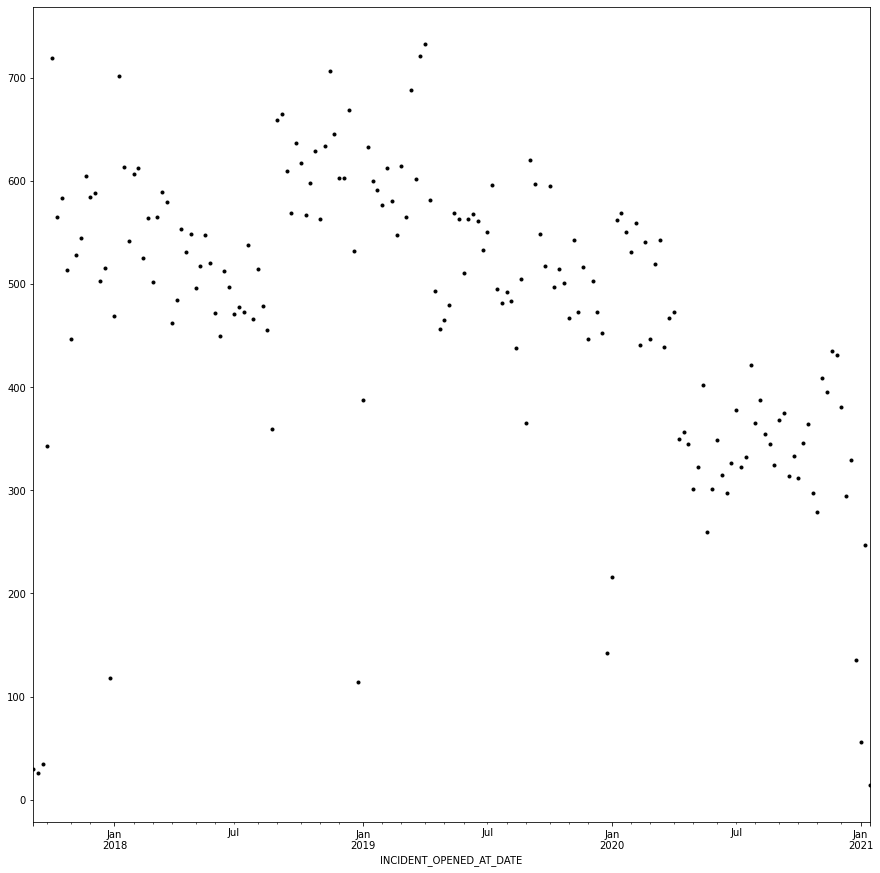

In [95]:
# Plot with dots
weekly_counts = df.groupby(['INCIDENT_OPENED_AT_DATE']).size()
weekly_counts = weekly_counts.resample('W').sum()
plt.figure(figsize=(15,15))
weekly_counts.plot(style='k.') # Use k- for dashed line plot

<font color='#ee555e'>Validate this definition of weekly average</font>

In [96]:
# Weekly average case numbers - which gives the average (daily) case count for each week?

# first resampling at least by day to get non-1 counts. otherwise, weekly averages will be 1 only because there will be as many data points as seconds and each second's case count will be 1 only.
weekly_average = df.groupby(['INCIDENT_OPENED_AT_DATE']).size().resample('D').sum()
weekly_average = weekly_average.resample('W').mean().reset_index(name='Count')
weekly_average

fig = px.line(weekly_average, x="INCIDENT_OPENED_AT_DATE", y="Count",
             title='Average number of weekly incidents',
             width=1200, height=900) 
fig.show()

## **Day-Wise Analysis**

In [97]:
# Daily case numbers

daily_counts = df.groupby(['INCIDENT_OPENED_AT_DATE']).size().reset_index(name="Count")
daily_counts = daily_counts.resample('D', on = 'INCIDENT_OPENED_AT_DATE').sum().reset_index()
print(daily_counts)

fig = px.bar(daily_counts, x="INCIDENT_OPENED_AT_DATE", y="Count",
             title='Number of Incidents over Days',
             width=1200, height=900) 
fig.show()

     INCIDENT_OPENED_AT_DATE  Count
0                 2017-09-05      2
1                 2017-09-06      6
2                 2017-09-07     12
3                 2017-09-08      8
4                 2017-09-09      0
...                      ...    ...
1222              2021-01-09      0
1223              2021-01-10      0
1224              2021-01-11      2
1225              2021-01-12      5
1226              2021-01-13      7

[1227 rows x 2 columns]


array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f95cc75d0>,
      dtype=object)

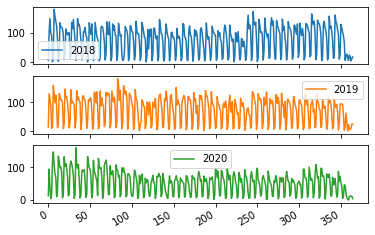

In [98]:
# Plotting over days across years 2018, 2019, 2020 in dataset
selected_years_df = df[(pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2018) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2019) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2020)]
selected_years_df = selected_years_df.groupby('INCIDENT_OPENED_AT_DATE').size()

# First group by day so that days with no case data can be filled with 0 counts before grouping by year to get equal number of data points for each year
selected_years_df = selected_years_df.resample('D').sum()
# drop the extra leap year date from 2020
selected_years_df = selected_years_df.drop(datetime.strptime('2020-02-29', '%Y-%m-%d'))

selected_years_df
groups = selected_years_df.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
  # print(str(name.year) + " = " + str(len(group)))
  # print(years)
  years[name.year] = group.values
years.plot(subplots=True, legend=True)
# plt.show()

More scalable way of dealing with leap years

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f9f97add410>,
      dtype=object)

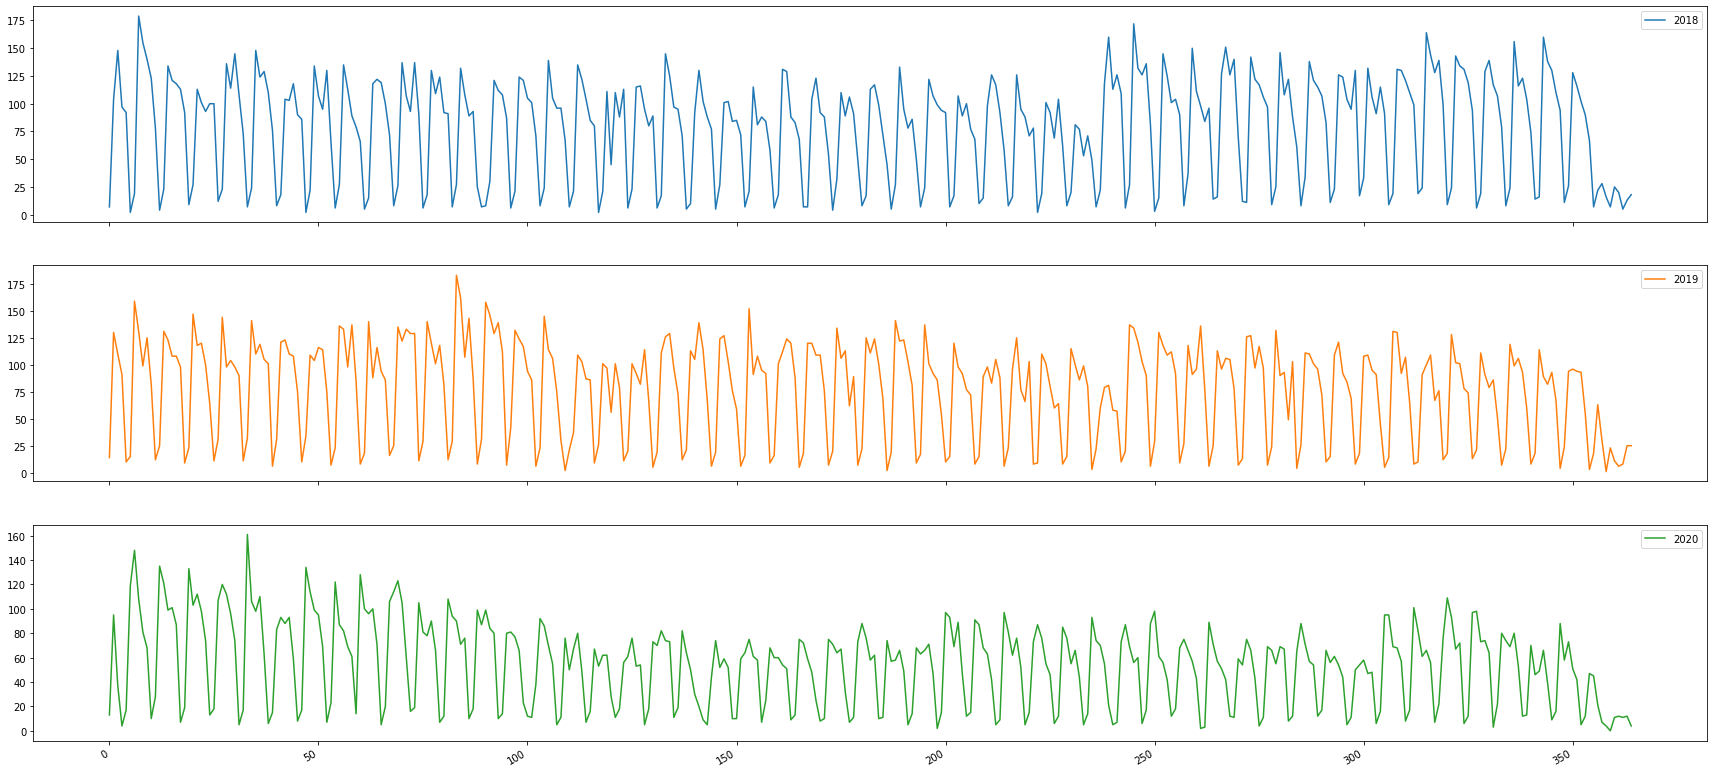

In [99]:
# Plotting over days across years 2018, 2019, 2020 in dataset
selected_years_df = df[(pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2018) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2019) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2020)]
selected_years_df = selected_years_df.groupby('INCIDENT_OPENED_AT_DATE').size()

# First group by day so that days with no case data can be filled with 0 counts before grouping by year to get equal number of data points for each year
selected_years_df = selected_years_df.resample('D').sum()
# drop the extra leap year date from 2020
selected_years_df = selected_years_df.drop(datetime.strptime('2020-02-29', '%Y-%m-%d'))

selected_years_df
groups = selected_years_df.groupby(pd.Grouper(freq='A'))
years = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
years = pd.DataFrame(years)
years.columns = range(2018,2021)
years.plot(subplots=True, legend=True, figsize=(30,15))
# plt.show()

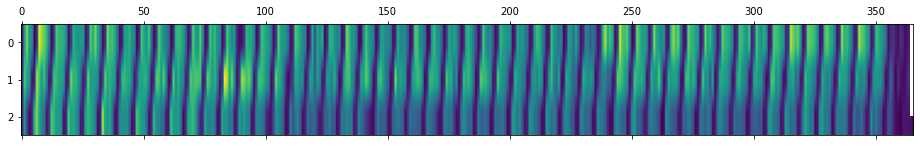

In [100]:
# Time Series Heat Maps
# A matrix of numbers can be plotted as a surface, where the values in each cell of the matrix are assigned a unique color.
# This is called a heatmap, as larger values can be drawn with warmer colors (yellows and reds) and smaller values can be drawn with cooler colors (blues and greens).

selected_years_df = df[(pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2018) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2019) | (pd.DatetimeIndex(df['INCIDENT_OPENED_AT_DATE']).year == 2020)]
selected_years_df = selected_years_df.groupby('INCIDENT_OPENED_AT_DATE').size()

selected_years_df = selected_years_df.resample('D').sum()

groups = selected_years_df.groupby(pd.Grouper(freq='A'))
years = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
years = pd.DataFrame(years)
years.columns = range(2018,2021)
years = years.T
plt.matshow(years, interpolation=None, aspect='auto')
plt.show()

# For convenience, the matrix is rotation (transposed) so that each row represents one year and each column one day. This provides a more intuitive, left-to-right layout of the data.
# So rows 0, 1 and 2 are years 2018, 2019 and 2020
